Supplement Material for the report

**“The *DO*s and *DON’T*s of Using Causal Inference Analysis Through Time Series in Geosciences Applications”**

written by **De Carli, J.C.A., 2021.**


Last edited by the Author: Oct.05.2021



For a detailed description of this research, please, read the [Report](https://drive.google.com/file/d/1N_gwhiu9LWqGOeaCR8YvKOS9ewtBrWxr/view?usp=sharing). This Colab notebook and report shall not be published or distributed. It was created for pedagogical purposes. for MSc and PhD students from the Skolkovo Institute of Science and technology.

If you have any questions or would like to discuss some topics and technicalities of the research topic, feel free to send me an email to jean.andradedecarli@skoltech.ru

# Installing necessary Libraries

Installing Python necessary packages and libraries that are not by default installed in GoogleColab.

**Matplotlib**

matplotlib is by default installed in Colab Notebooks. However, at the current time when this Colab Notebook is being created (Sept.2021) there is a version conflite in the matplotlib (3.2.2.) installed in colab by default and the version requeried (3.4.0 or superior) by the Tigramite Library, which is the main library for this work. 

At the current date (Sept. 2021) the last version of Matplotlib is 3.4.3.

* Make sure that you have Matplotlib 3.4.0 or superior installed in this notebook. Otherwise, your future plots will not work.

In [ ]:
!pip install -U matplotlib

     |████████████████████████████████| 10.3 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

**Tigramite** is the main package for Time-Series Analysis. And it can be find [here](https://github.com/jakobrunge/tigramite)

In [ ]:
pip install git+https://github.com/jakobrunge/tigramite.git

  Cloning https://github.com/jakobrunge/tigramite.git to /tmp/pip-req-build-_1gip0m5
  Running command git clone -q https://github.com/jakobrunge/tigramite.git /tmp/pip-req-build-_1gip0m5
  Created wheel for tigramite: filename=tigramite-4.2.2.1-cp37-cp37m-linux_x86_64.whl size=400204 sha256=36ac41bbdbe542055104875c1560044f84a9c822f15318424da836a8caf16672
  Stored in directory: /tmp/pip-ephem-wheel-cache-6sptom2e/wheels/3b/69/bd/533deb9f352d3b065cc74551e471ff9a0a41256eb8e1bfc5d6
Successfully built tigramite


In [ ]:
!pip install -U -q PyDrive # "-U -q PyDrive" necessary to import the simulated data from Gdrive to GoogleColab (2 Data Import)

**mpi4py**

Not necessary for the current status of the code in this notebook. However, necessary for further implementation of High-Performance Computing and Parallelized Scripts.

In [ ]:
!pip install mpi4py

     |████████████████████████████████| 2.4 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180607 sha256=278627e36317443987e7dc5db301155b09e959ae714341eb1f90bcc2d491505d
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6f2255
Successfully built mpi4py


**dcor** necessary for GPDC tests.

In [ ]:
!pip install dcor

**gpytorch** 

Necessary for GPDC_torch tests (not currently used in this Notebook)

In [ ]:
!pip install gpytorch

     |████████████████████████████████| 503 kB 5.1 MB/s 


In [ ]:
import os, sys, pickle
import numpy as np
import matplotlib
import sklearn
import tigramite
import pandas as pd
import time
import math

from mpi4py import MPI
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from matplotlib import pyplot as plt
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb, GPDCtorch
from tigramite.models import LinearMediation, Prediction
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/usr/local/lib/python3.7/dist-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Import
Choose one of the two methods.

## 1 Data import - Local Drive

*   It can take around *12 min* to upload.
*   Download the data from the link <[here](https://drive.google.com/drive/folders/1i7-2ktFUYRfEfj0bkMW8ksSDbVq9fWx0?usp=sharing)>
*   Upload the data in the Colab Environment. 
    * At the top-side-right corner of the this notebook, click on the "Files" icon (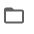), then on the "Upload to session storage" icon (icon2.png). Select the Synthetic Data that you just downloaded and wait for it to upload to the Colab Environment.

## 2 Data import - Google-drive link

*  it can take around *2 min* to upload.

* When running this line. It will generate a link, please click on this link in order for google to authenticate your registered email as an author. Then copy the generated authentication link and paste in the **blank below**, at "Enter Verification Code:" and **press Enter**.

```
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
```

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
start = time.time(); gstart = time.ctime(); print("Google-Colab local server time starts at:", gstart)

downloaded = drive.CreateFile({'id':'1nxcVjb5qcQiJsuh5ubxbGjAevUcurRhL'})
downloaded.GetContentFile('data_bhp0.pickle') 

downloaded = drive.CreateFile({'id':'1OpyZv47B3qHg_0ffNC_WFkMjyUe6F9q9'})
downloaded.GetContentFile('data_bhp1.pickle') 

downloaded = drive.CreateFile({'id':'1vMtyj2RJ1pnO-X9zK9mGzAlgHshd-hQ3'})
downloaded.GetContentFile('data_bhp2.pickle') 

downloaded = drive.CreateFile({'id':'1I1AR6JaHULitgBcAfsw0Hieu8UUijFMV'})
downloaded.GetContentFile('data_bhp3.pickle') 

downloaded = drive.CreateFile({'id':'1Ut3mS7H_9LTUVeY7VHJjIOKz5Bks-82M'})
downloaded.GetContentFile('data_bhp4.pickle') 

downloaded = drive.CreateFile({'id':'1yyXDQBv0rhjB1AB5ahUIH9SIaFK4AV4A'})
downloaded.GetContentFile('data_bhp5.pickle') 

downloaded = drive.CreateFile({'id':'1kQ6oAX4ZXJqkKnLVwZP-pR5A19Fd3tlQ'})
downloaded.GetContentFile('data_bhp6.pickle') 

downloaded = drive.CreateFile({'id':'1qXYZmcd6cUEyne1QSVCYwQmek7WXbmgN'})
downloaded.GetContentFile('data_bhp7.pickle') 

downloaded = drive.CreateFile({'id':'1EhTZGcc9dc6KKH67EelzshJJXo7CTW_V'})
downloaded.GetContentFile('data_bhp8.pickle') 

downloaded = drive.CreateFile({'id':'1hHqn1QXS33H06H16_CnVYIrOrOmrqBIv'})
downloaded.GetContentFile('data_bhp80.pickle')

downloaded = drive.CreateFile({'id':'1HRDJ2l0C_qrZASrm9xGAz8Vs2xb4QlAy'})
downloaded.GetContentFile('data_porohomo.pickle') 

end = time.time(); gend = time.ctime(); print(('This code-cell-run took'),end - start,'(s) to finish | ',(end-start)/60,' (min)'); 
print('Google-Colab local server time ends at:', gend)

Google-Colab local server time starts at: Mon Sep 27 15:29:42 2021
This code-cell-run took 97.4597749710083 (s) to finish |  1.6243295828501383  (min)
Google-Colab local server time ends at: Mon Sep 27 15:31:20 2021


## Checking if the Data has been uploaded correctely


*   After using one of the upload methods:
      
       Run the command "ls" and you should see a result as the picture below. It means that the data have been uploaded correctly to the Notebook.

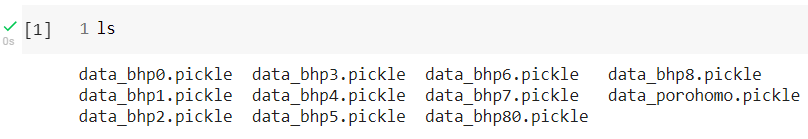


In [ ]:
ls

adc.json          data_bhp3.pickle  data_bhp7.pickle      sample_data/
data_bhp0.pickle  data_bhp4.pickle  data_bhp80.pickle
data_bhp1.pickle  data_bhp5.pickle  data_bhp8.pickle
data_bhp2.pickle  data_bhp6.pickle  data_porohomo.pickle


## After uploading the data
by using any of the methods.

In [ ]:
start = time.time(); gstart = time.ctime(); print("Google-Colab server local-time starts at:", gstart)
with open('data_bhp0.pickle', 'rb') as f:
    data0 = pickle.load(f)

with open('data_bhp1.pickle', 'rb') as f:
    data1 = pickle.load(f) 

with open('data_bhp2.pickle', 'rb') as f:
    data2 = pickle.load(f)

with open('data_bhp3.pickle', 'rb') as f:
    data3 = pickle.load(f) 

with open('data_bhp4.pickle', 'rb') as f:
    data4 = pickle.load(f)

with open('data_bhp5.pickle', 'rb') as f:
    data5 = pickle.load(f) 

with open('data_bhp6.pickle', 'rb') as f:
    data6 = pickle.load(f)

with open('data_bhp7.pickle', 'rb') as f:
    data7 = pickle.load(f) 

with open('data_bhp8.pickle', 'rb') as f:
    data8 = pickle.load(f) 

with open('data_bhp80.pickle', 'rb') as f:
    data80 = pickle.load(f)

with open('data_porohomo.pickle', 'rb') as f:
    datahomoporo = pickle.load(f)

end = time.time(); gend = time.ctime(); print(('This code-cell-run took'),end - start,'(s) to finish | ',(end-start)/60,' (min)'); 
print('Google-Colab server local-time ends at:', gend)

Google-Colab server local-time starts at: Mon Sep 27 15:31:20 2021
This code-cell-run took 2.0537991523742676 (s) to finish |  0.03422998587290446  (min)
Google-Colab server local-time ends at: Mon Sep 27 15:31:22 2021


*Normalizing the data, at the moment of the creation of this Notebook. We still investigating why our first-time step shows anomalous values. In order to minimize this erroneous influence in our causal approach, run the next cell.*

In [ ]:
# Normalizing
data0['rate'][4]['oil_rate'][0] = ((data0['rate'][4]['oil_rate'][1])+2)
data0['rate'][4]['water_rate'][0] = ((data0['rate'][4]['water_rate'][1])+0.04)

data1['rate'][4]['oil_rate'][0] = ((data1['rate'][4]['oil_rate'][1])+2)
data1['rate'][4]['water_rate'][0] = ((data1['rate'][4]['water_rate'][1])+0.04)
data1['rate'][0]['water_rate'] = ((-data1['rate'][0]['water_rate']))  # Negatives here
data1['rate'][1]['water_rate'] = ((-data1['rate'][1]['water_rate']))  # Negatives here
data1['rate'][2]['water_rate'] = ((-data1['rate'][2]['water_rate']))  # Negatives here
data1['rate'][3]['water_rate'] = ((-data1['rate'][3]['water_rate']))  # Negatives here

data2['rate'][4]['oil_rate'][0] = ((data2['rate'][4]['oil_rate'][1])+2)
data2['rate'][4]['water_rate'][0] = ((data2['rate'][4]['water_rate'][1])+0.04)

data3['rate'][4]['oil_rate'][0] = ((data3['rate'][4]['oil_rate'][1])+2)
data3['rate'][4]['water_rate'][0] = ((data3['rate'][4]['water_rate'][1])+0.04)

data4['rate'][4]['oil_rate'][0] = ((data4['rate'][4]['oil_rate'][1])+2)
data4['rate'][4]['water_rate'][0] = ((data4['rate'][4]['water_rate'][1])+0.04)

data5['rate'][4]['oil_rate'][0] = ((data5['rate'][4]['oil_rate'][1])+2)
data5['rate'][4]['water_rate'][0] = ((data5['rate'][4]['water_rate'][1])+0.04)

data6['rate'][4]['oil_rate'][0] = ((data6['rate'][4]['oil_rate'][1])+2)
data6['rate'][4]['water_rate'][0] = ((data6['rate'][4]['water_rate'][1])+0.04)

data7['rate'][4]['oil_rate'][0] = ((data7['rate'][4]['oil_rate'][1])+2)
data7['rate'][4]['water_rate'][0] = ((data7['rate'][4]['water_rate'][1])+0.04)

data8['rate'][4]['oil_rate'][0] = ((data8['rate'][4]['oil_rate'][1])+2)
data8['rate'][4]['water_rate'][0] = ((data8['rate'][4]['water_rate'][1])+0.04)

# Functions
Defining Useful Functions.

## Plot

### Correlation between two time-series

In [ ]:
def j_corrcoef_2ts_plot(ts1,ts2,lag):
  """input ts1, ts2, lag Number. PLOTcalculated correlation between 2 time-series"""
  y = 0
  a = np.zeros((lag))
  for i, j, k in zip(range(0,lag), range(1,(lag+1)), range(1,(lag+1))):
    a[i] = np.corrcoef(ts1[:-j], ts2[k:])[0, 1]
  plt.figure()
  plt.figure(figsize=[28, 8])
  plt.plot(a,'o')
  x_coordinates = [(lag), 0]; y_coordinates = [0, 0]
  plt.plot(x_coordinates, y_coordinates,'--',linewidth=1)
  plt.ylabel('corr coef',fontsize=18)
  plt.xlabel('lags - \u03C4',fontsize=18)
  plt.grid(linestyle='--', linewidth=0.5)

<Figure size 432x288 with 0 Axes>

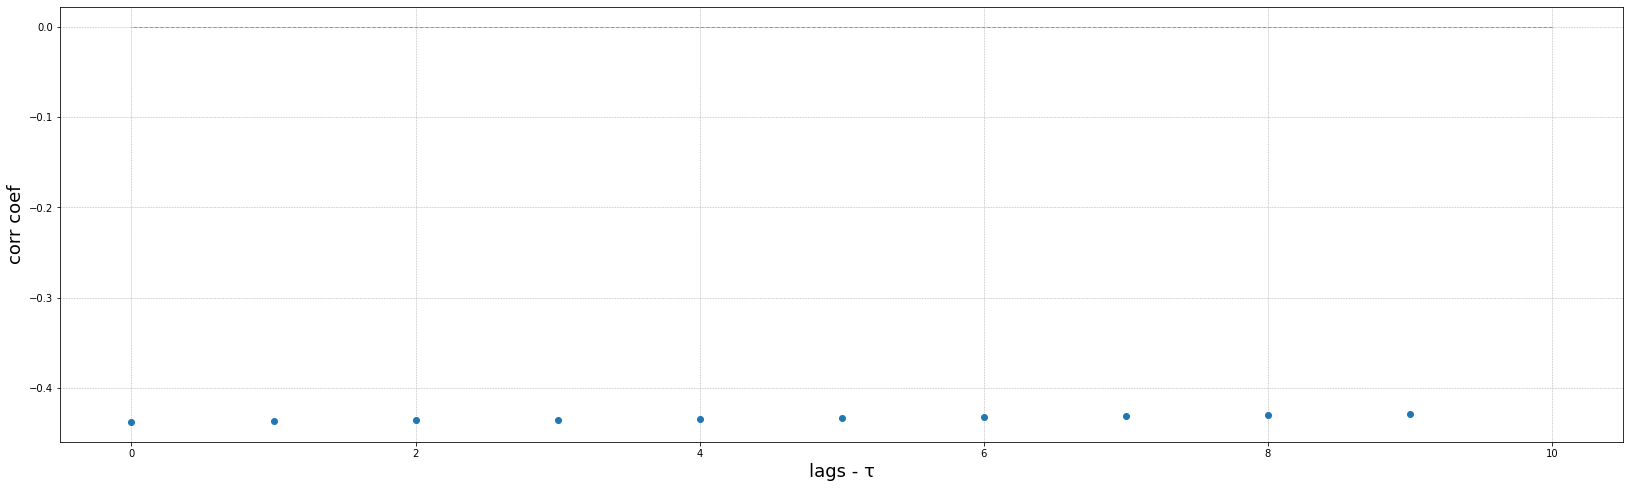

In [ ]:
j_corrcoef_2ts_plot(data1['rate'][4]['oil_rate'],data1['rate'][4]['water_rate'],10)

### All BHP curves of a dataset

In [ ]:
def jp_all_bhp_cruves(dataset,dataset_label):
    """Plot a single image with all Inj BHP.
    dataset = chosen_dataset
    dataset_label = 'Data 01 ALL (4) inj wells bhp curvers'"""
    plt.figure(figsize=[16, 8])
    plt.plot(dataset['time'], dataset['bhp'][0], label='inj 1')
    plt.plot(dataset['time'], dataset['bhp'][1], label='inj 2')
    plt.plot(dataset['time'], dataset['bhp'][2], label='inj 3')
    plt.plot(dataset['time'], dataset['bhp'][3], label='inj 4')
    plt.ylabel('bhp, Pa',fontsize=16)
    plt.xlabel('days',fontsize=16)
    plt.title(dataset_label,fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print('inj 1 bhp: [Max ',(np.max(dataset['bhp'][0])),']',' [Min',(np.min(dataset['bhp'][0])),']')
    print('inj 2 bhp: [Max ',(np.max(dataset['bhp'][1])),']',' [Min',(np.min(dataset['bhp'][1])),']')
    print('inj 3 bhp: [Max ',(np.max(dataset['bhp'][2])),']',' [Min',(np.min(dataset['bhp'][2])),']')
    print('inj 4 bhp: [Max ',(np.max(dataset['bhp'][3])),']',' [Min',(np.min(dataset['bhp'][3])),']')
    plt.show()
    return;

inj 1 bhp: [Max  10000000.0 ]  [Min 1000000.0 ]
inj 2 bhp: [Max  9000000.0 ]  [Min 1000000.0 ]
inj 3 bhp: [Max  10000000.0 ]  [Min 1000000.0 ]
inj 4 bhp: [Max  8000000.0 ]  [Min 1000000.0 ]


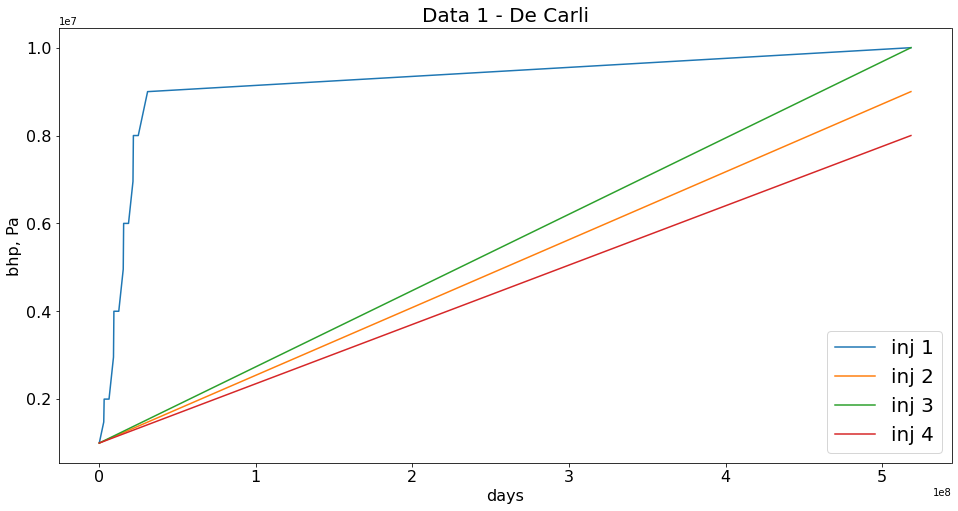

In [ ]:
jp_all_bhp_cruves(data1, 'Data 1 - De Carli')

### All BHP curves of a dataset + Pro BHP

In [ ]:
def jp_all_bhp_cruves_Pro(dataset,dataset_label):
    """Plot a single image with all Inj BHP + pro BHP.
    dataset = chosen_dataset
    dataset_label = 'Data 01 ALL (4) inj wells bhp curvers'"""
    plt.figure(figsize=[16, 8])
    plt.plot(dataset['time'], dataset['bhp'][0], label='inj 1')
    plt.plot(dataset['time'], dataset['bhp'][1], label='inj 2')
    plt.plot(dataset['time'], dataset['bhp'][2], label='inj 3')
    plt.plot(dataset['time'], dataset['bhp'][3], label='inj 4')
    plt.plot(dataset['time'], dataset['bhp'][4], label='Pro', linestyle='--')
    plt.ylabel('bhp, Pa',fontsize=16)
    plt.xlabel('days',fontsize=16)
    plt.title(dataset_label,fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print('inj 1 bhp: [Max ',(np.max(dataset['bhp'][0])),']',' [Min',(np.min(dataset['bhp'][0])),']')
    print('inj 2 bhp: [Max ',(np.max(dataset['bhp'][1])),']',' [Min',(np.min(dataset['bhp'][1])),']')
    print('inj 3 bhp: [Max ',(np.max(dataset['bhp'][2])),']',' [Min',(np.min(dataset['bhp'][2])),']')
    print('inj 4 bhp: [Max ',(np.max(dataset['bhp'][3])),']',' [Min',(np.min(dataset['bhp'][3])),']')
    plt.show()
    return;

inj 1 bhp: [Max  10000000.0 ]  [Min 1000000.0 ]
inj 2 bhp: [Max  9000000.0 ]  [Min 1000000.0 ]
inj 3 bhp: [Max  10000000.0 ]  [Min 1000000.0 ]
inj 4 bhp: [Max  8000000.0 ]  [Min 1000000.0 ]


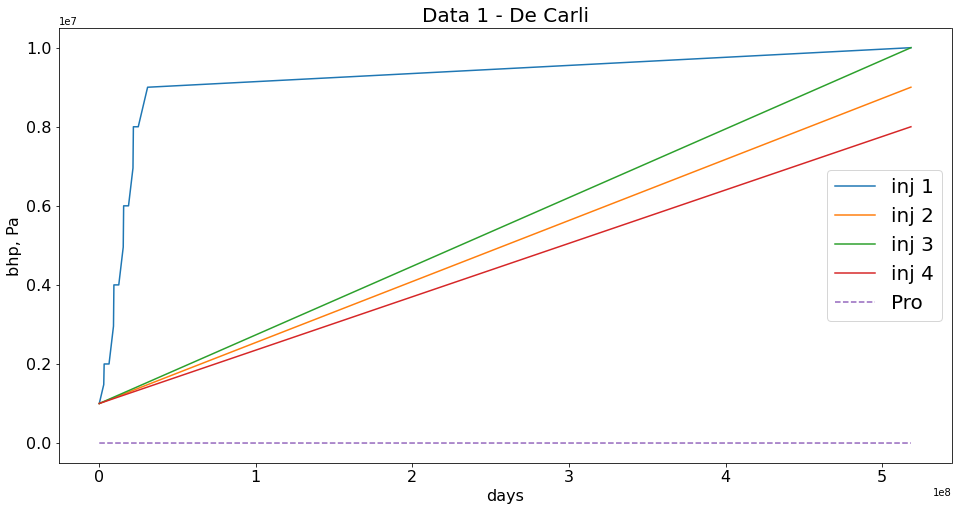

In [ ]:
jp_all_bhp_cruves_Pro(data1, 'Data 1 - De Carli')

### Prod curves of a dataset
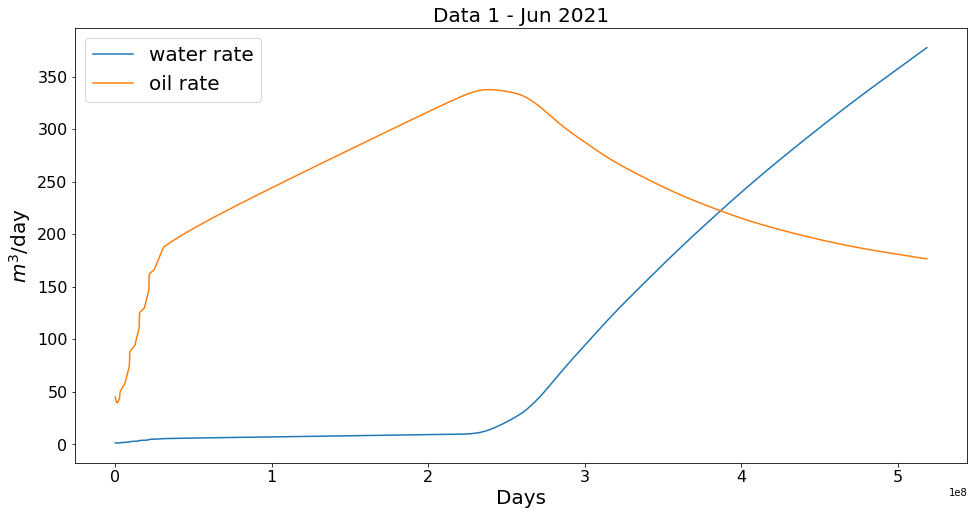

In [ ]:
def jp_prod_curves(dataset,dataset_label):
    """Plot Production curves (Oil x Water). e.g. ##dataset = data01 ##dataset_label = 'Data 01 Oil and Water production curvers'"""
    plt.figure(figsize=[16, 8])
    plt.plot(dataset['time'], dataset['rate'][4]['water_rate'], label='water rate')
    plt.plot(dataset['time'], dataset['rate'][4]['oil_rate'], label ='oil rate')
    plt.ylabel('$m^3$/day',fontsize=20)
    plt.xlabel('Days',fontsize=20)
    plt.title(dataset_label,fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    return;

### All Inj rates of a dataset
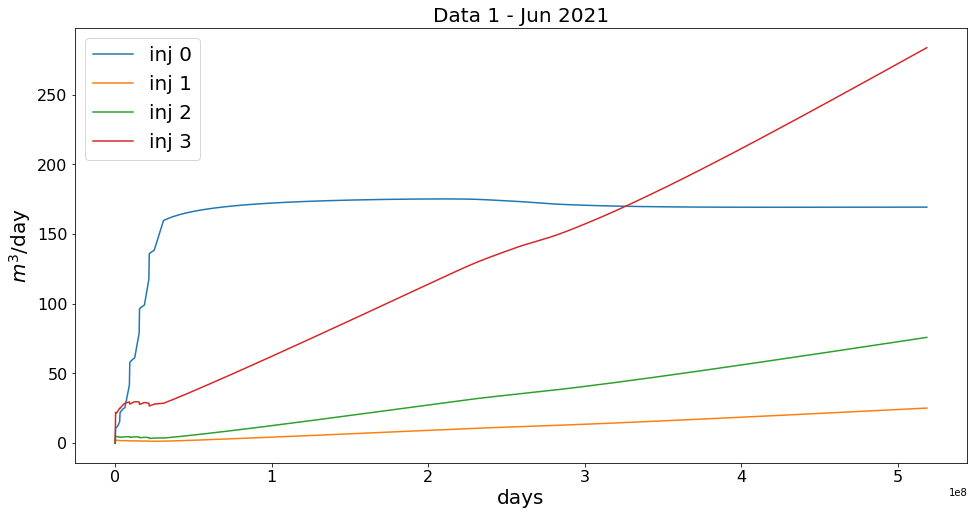

In [ ]:
def jp_all_inj_curves(dataset,dataset_label):
    """Plot all (4) Inj Wells (ratios). e.g. ##dataset = data01 ##dataset_label = 'Data 01 All Injection curvers'"""
    plt.figure(figsize=[16, 8])
    plt.plot(dataset['time'], dataset['rate'][0]['water_rate'], label='inj 0')
    plt.plot(dataset['time'], dataset['rate'][1]['water_rate'], label='inj 1')
    plt.plot(dataset['time'], dataset['rate'][2]['water_rate'], label='inj 2')
    plt.plot(dataset['time'], dataset['rate'][3]['water_rate'], label='inj 3')
    plt.ylabel('$m^3$/day',fontsize=20)
    plt.xlabel('days',fontsize=20)
    plt.title(dataset_label,fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print('inj 0: [Max ',(np.max(dataset['rate'][0]['water_rate'])),']',' [Min',(np.min(dataset['rate'][0]['water_rate'])),']')
    print('inj 1: [Max ',(np.max(dataset['rate'][1]['water_rate'])),']',' [Min',(np.min(dataset['rate'][1]['water_rate'])),']')
    print('inj 2: [Max ',(np.max(dataset['rate'][2]['water_rate'])),']',' [Min',(np.min(dataset['rate'][2]['water_rate'])),']')
    print('inj 3: [Max ',(np.max(dataset['rate'][3]['water_rate'])),']',' [Min',(np.min(dataset['rate'][3]['water_rate'])),']')
    plt.show()
    return;

### All In rates of a dataset + Pro rate
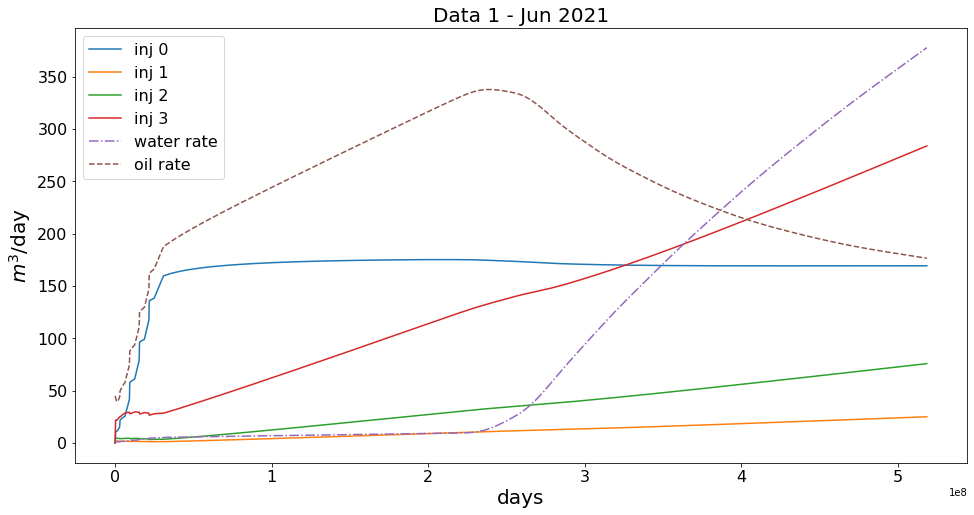

In [ ]:
def jp_all_inj_curves_Pro(dataset,dataset_label):
    """Plot (4) Inj Wells (ratios). e.g. ##dataset = data01 ##dataset_label = 'Data 01 All Injection curvers'"""
    plt.figure(figsize=[16, 8])
    plt.plot(dataset['time'], dataset['rate'][0]['water_rate'], label='inj 0')
    plt.plot(dataset['time'], dataset['rate'][1]['water_rate'], label='inj 1')
    plt.plot(dataset['time'], dataset['rate'][2]['water_rate'], label='inj 2')
    plt.plot(dataset['time'], dataset['rate'][3]['water_rate'], label='inj 3')
    plt.plot(dataset['time'], dataset['rate'][4]['water_rate'], label='water rate', linestyle= '-.')
    plt.plot(dataset['time'], dataset['rate'][4]['oil_rate'], label ='oil rate', linestyle= '--')
    plt.ylabel('$m^3$/day',fontsize=20)
    plt.xlabel('days',fontsize=20)
    plt.title(dataset_label,fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print('inj 0: [Max ',(np.max(dataset['rate'][0]['water_rate'])),']',' [Min',(np.min(dataset['rate'][0]['water_rate'])),']')
    print('inj 1: [Max ',(np.max(dataset['rate'][1]['water_rate'])),']',' [Min',(np.min(dataset['rate'][1]['water_rate'])),']')
    print('inj 2: [Max ',(np.max(dataset['rate'][2]['water_rate'])),']',' [Min',(np.min(dataset['rate'][2]['water_rate'])),']')
    print('inj 3: [Max ',(np.max(dataset['rate'][3]['water_rate'])),']',' [Min',(np.min(dataset['rate'][3]['water_rate'])),']')
    plt.show()
    return;

### Plot all pro curves from all dataset

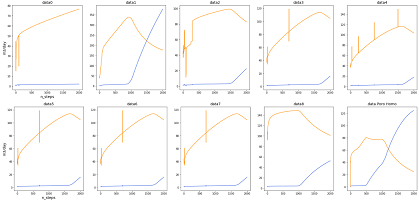

In [ ]:
def jp_all_prod_curves_datasets():
  """Plot all Pro Curves from all dataset in this notebook"""
  figsize_x = 28; figsize_y = 6; fsize= 14
  c_inj0 = 'deepskyblue'; c_inj1 = 'red'; c_inj2 = 'goldenrod'; c_inj3 = 'green'; c_pro_o = 'darkorange'; c_pro_w = 'royalblue';
  n_t_steps = np.array(len(data1['time']))

  fig0, axs0 = plt.subplots(ncols=5, figsize=(figsize_x,figsize_y))
  axs0[0].set_ylabel('m3/day', fontsize=14)
  axs0[0].set_xlabel('n_steps', fontsize=14)
  axs0[0].set_title('data0',fontsize=14)
  axs0[0].plot(data0['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs0[0].plot(data0['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs0[1].set_title('data1',fontsize=14)
  axs0[1].plot(data1['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs0[1].plot(data1['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs0[2].set_title('data2',fontsize=14)
  axs0[2].plot(data2['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs0[2].plot(data2['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs0[3].set_title('data3',fontsize=14)
  axs0[3].plot(data3['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs0[3].plot(data3['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs0[4].set_title('data4',fontsize=14)
  axs0[4].plot(data4['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs0[4].plot(data4['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  fig1, axs1 = plt.subplots(ncols=5, figsize=(figsize_x,figsize_y))
  axs1[0].set_ylabel('m3/day', fontsize=14)
  axs1[0].set_xlabel('n_steps', fontsize=14)
  axs1[0].set_title('data5',fontsize=14)
  axs1[0].plot(data5['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs1[0].plot(data5['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs1[1].set_title('data6',fontsize=14)
  axs1[1].plot(data6['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs1[1].plot(data6['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs1[2].set_title('data7',fontsize=14)
  axs1[2].plot(data7['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs1[2].plot(data7['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs1[3].set_title('data8',fontsize=14)
  axs1[3].plot(data8['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs1[3].plot(data8['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)

  axs1[4].set_title('data Poro Homo',fontsize=14)
  axs1[4].plot(datahomoporo['rate'][4]['water_rate'], label='water', color=c_pro_w)
  axs1[4].plot(datahomoporo['rate'][4]['oil_rate'], label='Oil', color=c_pro_o)


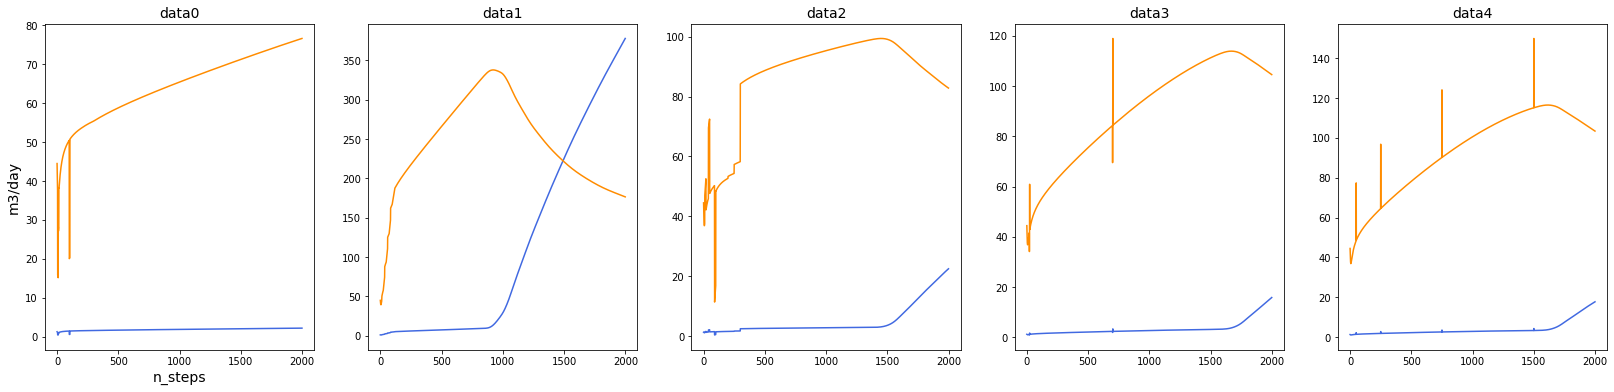

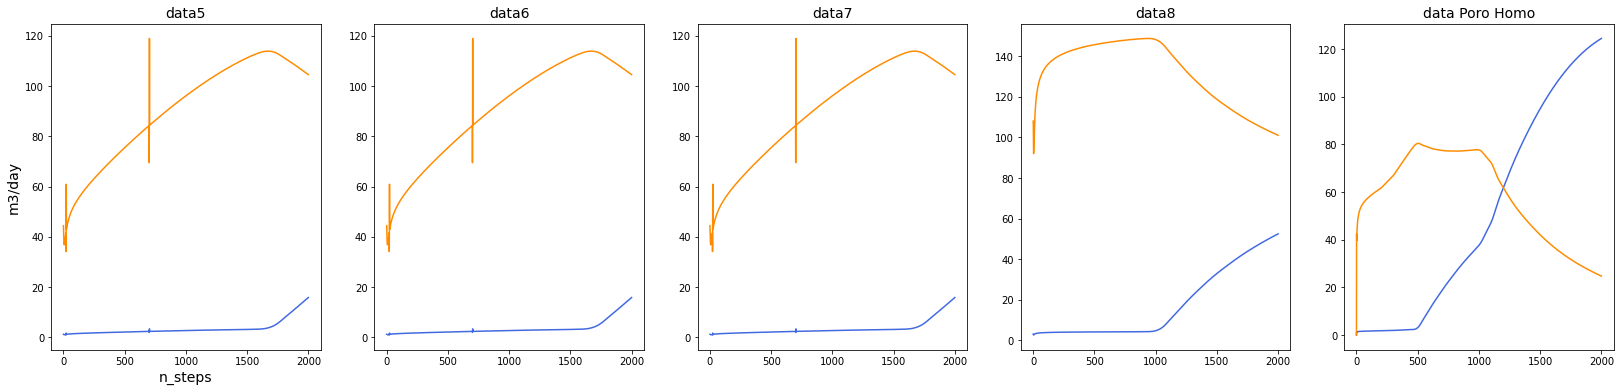

In [ ]:
jp_all_prod_curves_datasets()

### Multi Axis BHP & Inj rates

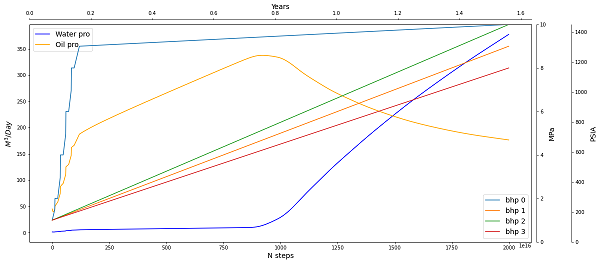

In [ ]:
def jp_multi_axis(dataset):
  """Enter a database"""
  d = dataset
  fontsize = 14;  p2_color ='green';
  fig, host = plt.subplots(figsize=(18,8)) # (width, height))
  par1 = host.twinx()
  par2 = host.twinx()
  par3 = host.twiny()
  par1.set_ylim(0,(max(d['bhp'][0])/1e6)) # MPa
  par1.set_ylabel("MPa", fontsize=fontsize)
  par2.set_ylim(0, (max(d['bhp'][0]))*0.00014503773800722) # in PSIA
  par2.set_ylabel("PSIA", fontsize=fontsize)
  par3.set_xlim(0,(max(d['time'])/(3.17098e-8))) # Years
  par3.set_xlabel("Years", fontsize=fontsize)
  p1, = host.plot(d['rate'][4]['water_rate'], color='blue', label="Water pro")
  p1, = host.plot(d['rate'][4]['oil_rate'],   color='orange', label="Oil pro")
  host.set_xlabel("N steps", fontsize=fontsize)
  host.set_ylabel("$M^3/Day$", fontsize=fontsize)
  p2, = par1.plot(d['bhp'][0]/1e6, label="bhp 0")
  p2, = par1.plot(d['bhp'][1]/1e6, label="bhp 1")
  p2, = par1.plot(d['bhp'][2]/1e6, label="bhp 2")
  p2, = par1.plot(d['bhp'][3]/1e6, label="bhp 3")
  host.legend(loc='upper left', fontsize = fontsize)
  par1.legend(loc='lower right', fontsize = fontsize)
  par1.spines['right'].set_position(('outward', 10))
  par2.spines['right'].set_position(('outward', 80))
  par3.spines['top'].set_position(('outward', 10))
  plt.plot(); 

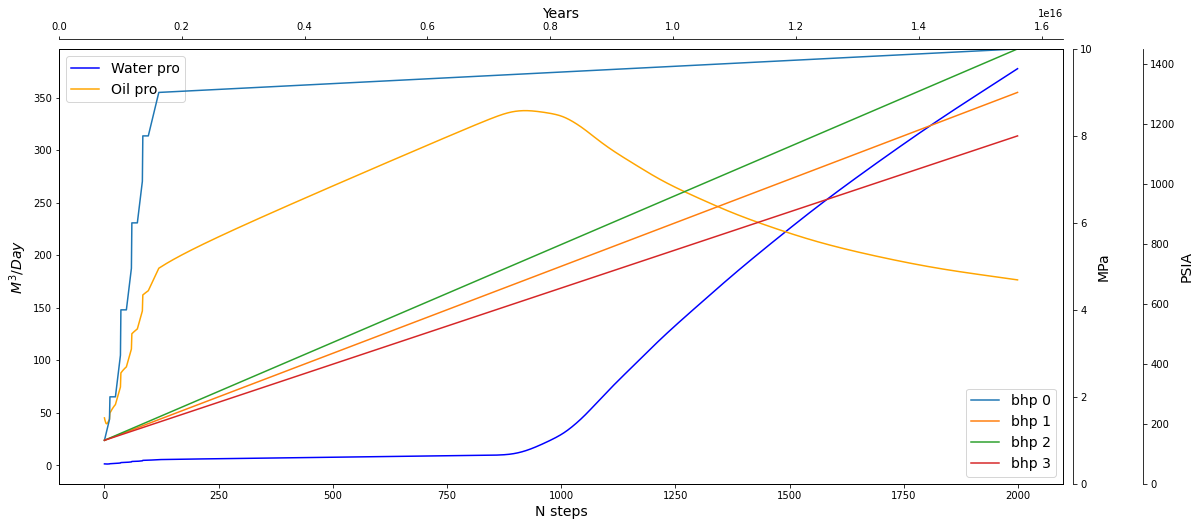

In [ ]:
jp_multi_axis(data1)

### Windows for data1

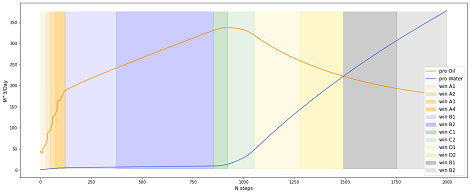

In [ ]:
def jp_windows_data1():
  """ Plot windows cut for data DATA1"""
  
  # "windowns" that I decide to cut
  a = [0, 30, 50, 75, 120] # cuts for window A
  b = [121,375,850]  # cuts for window B
  c = [851, 920, 1050] # cuts for window C
  d = [1051, 1280, 1490] # cuts for window D
  e = [1491, 1750, 2000] # cuts for window E
  fig =  plt.subplots(figsize=(20,8)) # cuts for window D

  ac = 'orange'
  matplotlib.pyplot.axvspan(a[0], a[1], 0.05, 0.95, color = ac, label= 'win A1', alpha = 0.1)
  matplotlib.pyplot.axvspan(a[1], a[2], 0.05, 0.95, color = ac, label= 'win A2', alpha = 0.2)
  matplotlib.pyplot.axvspan(a[2], a[3], 0.05, 0.95, color = ac, label= 'win A3', alpha = 0.3)
  matplotlib.pyplot.axvspan(a[3], a[4], 0.05, 0.95, color = ac, label= 'win A4', alpha = 0.4)

  matplotlib.pyplot.axvspan(b[0], b[1], 0.05, 0.95, color = 'blue', label= 'win B1', alpha = 0.1)
  matplotlib.pyplot.axvspan(b[1], b[2], 0.05, 0.95, color = 'blue', label= 'win B2', alpha = 0.2)

  matplotlib.pyplot.axvspan(c[0], c[1], 0.05, 0.95, color = 'green', label= 'win C1', alpha = 0.2)
  matplotlib.pyplot.axvspan(c[1], c[2], 0.05, 0.95, color = 'green', label= 'win C2', alpha = 0.1)

  matplotlib.pyplot.axvspan(d[0], d[1], 0.05, 0.95, color = 'gold', label= 'win D1', alpha = 0.1)
  matplotlib.pyplot.axvspan(d[1], d[2], 0.05, 0.95, color = 'gold', label= 'win D2', alpha = 0.2)

  matplotlib.pyplot.axvspan(e[0], e[1], 0.05, 0.95, color = 'black', label= 'win B1', alpha = 0.2)
  matplotlib.pyplot.axvspan(e[1], e[2], 0.05, 0.95, color = 'black', label= 'win B2', alpha = 0.1)
  plt.plot(data1['rate'][4]['oil_rate'], color = 'darkorange', label = 'pro Oil')
  plt.plot(data1['rate'][4]['water_rate'], color = 'royalblue', label = 'pro Water')
  plt.legend(loc = 'lower right', fontsize=12)
  plt.xlabel('N steps',fontsize=12)
  plt.ylabel('M^3/Day',fontsize=12)
  plt.plot()

### Close-up windows for data1
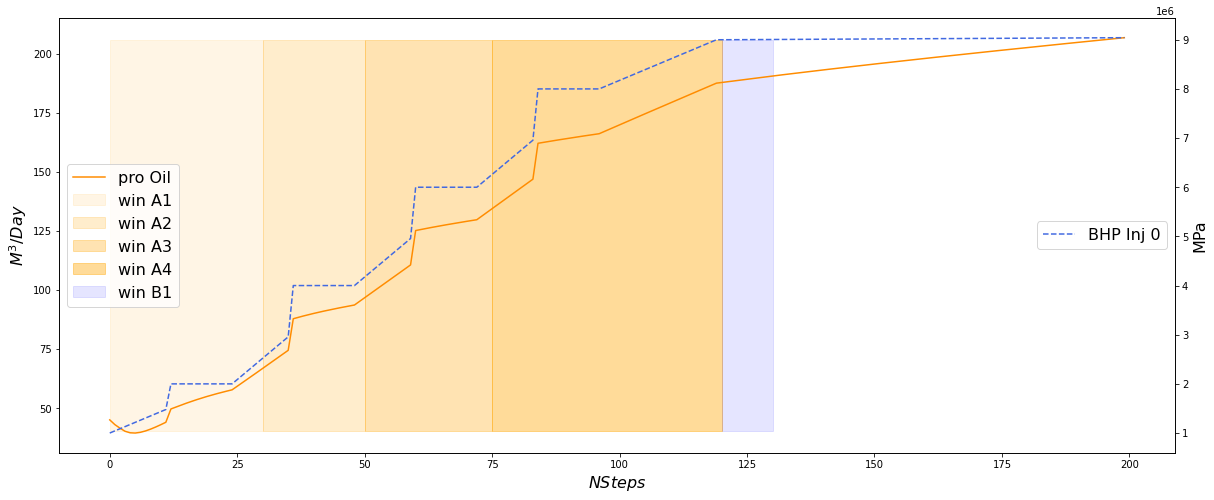

In [ ]:
def jp_closeup_win_data1():
# "windowns" that I decide to cut
  a = [0, 30, 50, 75, 120] # cuts for window A
  b = [121,375,850]  # cuts for window B
  c = [851, 920, 1050] # cuts for window C
  d = [1051, 1280, 1490] # cuts for window D
  e = [1491, 1750, 2000] # cuts for window E
  fig, ax = plt.subplots(figsize=(20,8))
  fontsize = 16
  ac = 'orange'
  matplotlib.pyplot.axvspan(a[0], a[1], 0.05, 0.95, color = ac, label= 'win A1', alpha = 0.1)
  matplotlib.pyplot.axvspan(a[1], a[2], 0.05, 0.95, color = ac, label= 'win A2', alpha = 0.2)
  matplotlib.pyplot.axvspan(a[2], a[3], 0.05, 0.95, color = ac, label= 'win A3', alpha = 0.3)
  matplotlib.pyplot.axvspan(a[3], a[4], 0.05, 0.95, color = ac, label= 'win A4', alpha = 0.4)
  matplotlib.pyplot.axvspan(b[0]-1, 130, 0.05, 0.95, color = 'blue', label= 'win B1', alpha = 0.1)

  ax.plot(data1['rate'][4]['oil_rate'][:200], color = 'darkorange', label = 'pro Oil')
  ax.legend(loc = 'center left', fontsize=fontsize)
  ax.set_ylabel('$M^3/Day$', fontsize=fontsize)
  ax.set_xlabel('$N Steps$', fontsize=fontsize)

  ax1 = ax.twinx()
  ax1.plot(data1['bhp'][0][:200], color = 'royalblue', linestyle = '--', label = 'BHP Inj 0')

  ax1.set_xlabel('N steps')
  ax1.set_ylabel('MPa', fontsize=fontsize)
  ax1.legend(loc = 'center right', fontsize=fontsize)

### Inj in diff win

Plot each injector rates in separeted windows

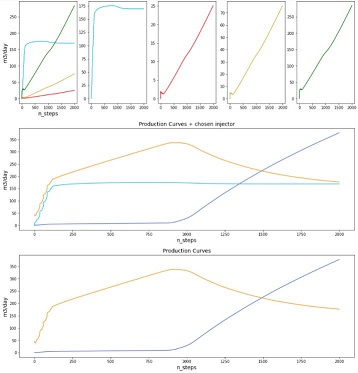

In [ ]:
def jp_inj_pro_diff_win(d1,inj_n ):
  """Insert a dataset and a index_n of a well [0...3]"""
  figsize_x = 16; figsize_y = 5; fsize= 5
  c_inj0 = 'deepskyblue'; c_inj1 = 'red'; c_inj2 = 'goldenrod'; c_inj3 = 'green'; c_prod_o = 'darkorange'; c_prod_w = 'royalblue';
  n_t_steps = np.array(len(d1['time']))
  fig0, axs0 = plt.subplots(ncols=5, figsize=(figsize_x,figsize_y))
  axs0[0].set_ylabel('m3/day', fontsize=14)
  axs0[0].set_xlabel('n_steps', fontsize=14)
  axs0[0].set_title('All inj',fontsize=14)
  axs0[0].plot(d1['rate'][0]['water_rate'], label='inj 0', color=c_inj0)
  axs0[0].plot(d1['rate'][1]['water_rate'], label='inj 1', color=c_inj1)
  axs0[0].plot(d1['rate'][2]['water_rate'], label='inj 2', color=c_inj2)
  axs0[0].plot(d1['rate'][3]['water_rate'], label='inj 3', color=c_inj3)
  axs0[1].set_title('inj 0',fontsize=14)
  axs0[1].plot(d1['rate'][0]['water_rate'], label='inj 0', color=c_inj0)
  axs0[2].set_title('inj 1',fontsize=14)
  axs0[2].plot(d1['rate'][1]['water_rate'], label='inj 1', color=c_inj1)
  axs0[3].set_title('inj 2',fontsize=14)
  axs0[3].plot(d1['rate'][2]['water_rate'], label='inj 2', color=c_inj2)
  axs0[4].set_title('inj 3',fontsize=14)
  axs0[4].plot(d1['rate'][3]['water_rate'], label='inj 3', color=c_inj3)

  if inj_n == 0:
    fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
    axs2.set_title('Production Curves + chosen injector',fontsize=14)
    axs2.set_ylabel('m3/day',fontsize=14)
    axs2.set_xlabel('n_steps',fontsize=14)
    axs2.plot(d1['rate'][0]['water_rate'], label='inj 0', color=c_inj0)
    axs2.plot(d1['rate'][4]['water_rate'], label='Water Prod', color=c_prod_w)
    axs2.plot(d1['rate'][4]['oil_rate'], label='Oil Prod', color=c_prod_o)

  if inj_n == 1:
    fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
    axs2.set_title('Production Curves + chosen injector',fontsize=14)
    axs2.set_ylabel('m3/day',fontsize=14)
    axs2.set_xlabel('n_steps',fontsize=14)
    axs2.plot(d1['rate'][1]['water_rate'], label='inj 1', color=c_inj1)
    axs2.plot(d1['rate'][4]['water_rate'], label='Water Prod', color=c_prod_w)
    axs2.plot(d1['rate'][4]['oil_rate'], label='Oil Prod', color=c_prod_o)

  if inj_n == 2:
    fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
    axs2.set_title('Production Curves + chosen injector',fontsize=14)
    axs2.set_ylabel('m3/day',fontsize=14)
    axs2.set_xlabel('n_steps',fontsize=14)
    axs2.plot(d1['rate'][2]['water_rate'], label='inj 2', color=c_inj2)
    axs2.plot(d1['rate'][4]['water_rate'], label='Water Prod', color=c_prod_w)
    axs2.plot(d1['rate'][4]['oil_rate'], label='Oil Prod', color=c_prod_o)

  if inj_n == 3:
    fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
    axs2.set_title('Production Curves + chosen injector',fontsize=14)
    axs2.set_ylabel('m3/day',fontsize=14)
    axs2.set_xlabel('n_steps',fontsize=14)
    axs2.plot(d1['rate'][3]['water_rate'], label='inj 3', color=c_inj3)
    axs2.plot(d1['rate'][4]['water_rate'], label='Water Prod', color=c_prod_w)
    axs2.plot(d1['rate'][4]['oil_rate'], label='Oil Prod', color=c_prod_o)
  
  if inj_n >3:
    print("Please choose input 0, 1, 2, 3 for inj_n")

  fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
  axs1.set_title('Production Curves',fontsize=14)
  axs1.set_ylabel('m3/day',fontsize=14)
  axs1.set_xlabel('n_steps',fontsize=14)
  axs1.plot(d1['rate'][4]['water_rate'], label='Water Prod', color=c_prod_w)
  axs1.plot(d1['rate'][4]['oil_rate'], label='Oil Prod', color=c_prod_o)

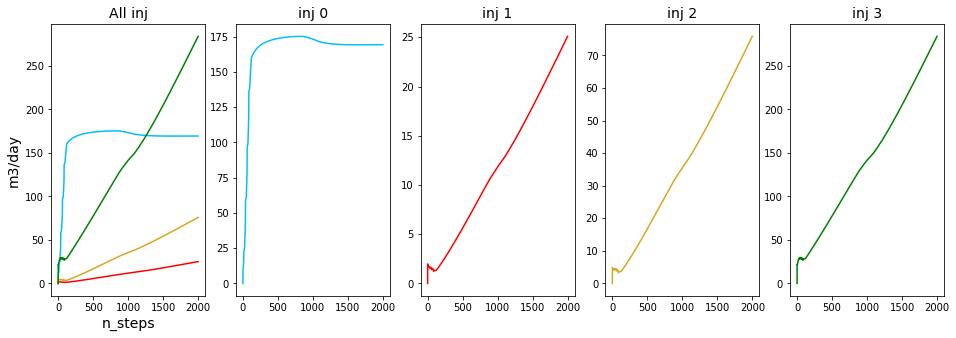

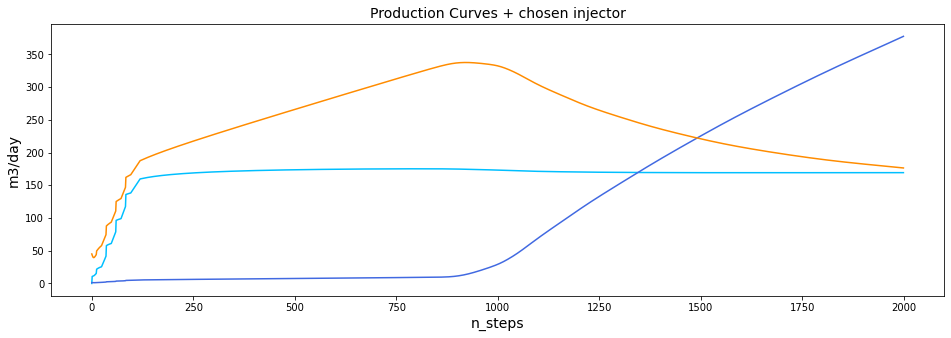

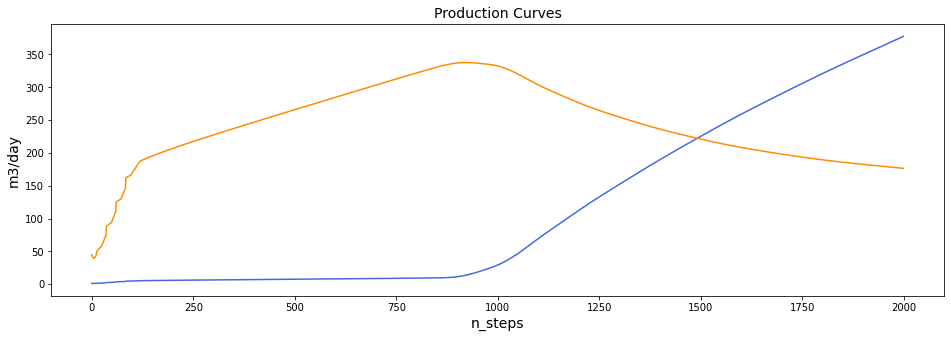

In [ ]:
jp_inj_pro_diff_win(data1,0)

## Tigramite related

### tg.data 2 vars - inj

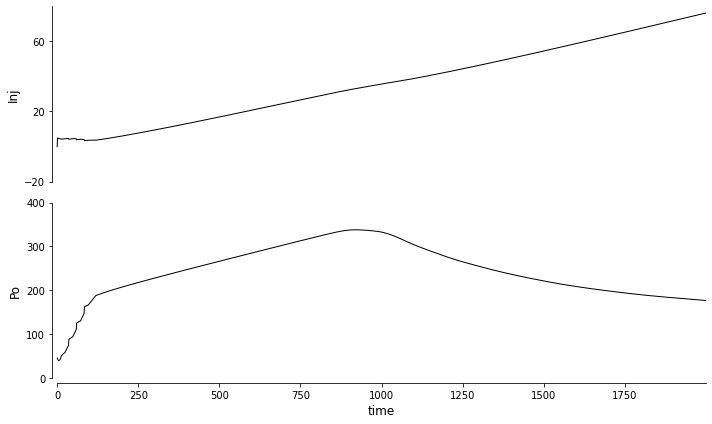

In [ ]:
def jtg_2vars_inj(chosen_data_set, inj_n):
    """inj_n: [0...3]. Retunr tg.dataframe of 2 variables: 1 inj and Pro."""
    N = 2
    T = (len(chosen_data_set['time']))
    datax = np.zeros((T,N))
    datax[:,0] = chosen_data_set['rate'][inj_n]['water_rate']
    datax[:,1] = chosen_data_set['rate'][4]['oil_rate']
    var_names01 = [r'Inj', r'Po']
    dataframe01 = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names01)
    tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
    return dataframe01;

###tg.data 5 vars - Inj

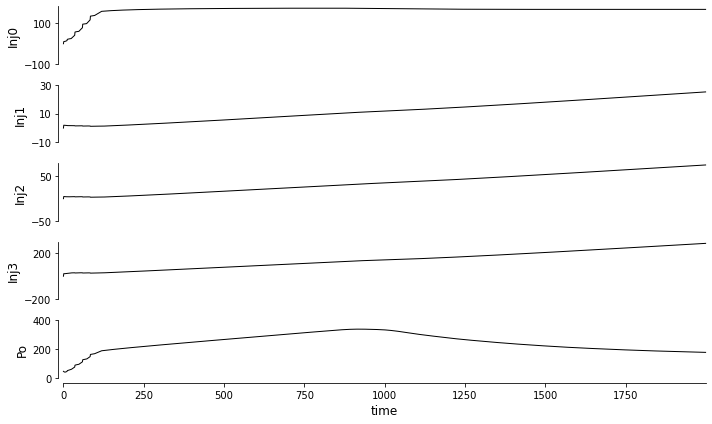

In [ ]:
def jtg_5vars_inj(chosen_data_set): # "tg/TG" stands for TIGRAMITE; "inj" means that this TG dataframe will be build with Injection rates
    """Retunr tg.dataframe of 5 variables: 4 injections and PRODUCTION OF 'OIL'."""
    N = 5
    T = (len(chosen_data_set['time']))
    datax = np.zeros((T,N))

    datax[:,0] = chosen_data_set['rate'][0]['water_rate']
    datax[:,1] = chosen_data_set['rate'][1]['water_rate']
    datax[:,2] = chosen_data_set['rate'][2]['water_rate']
    datax[:,3] = chosen_data_set['rate'][3]['water_rate']
    datax[:,4] = chosen_data_set['rate'][4]['oil_rate']
    print('Vars(',N,') = 4 inj wells, 1 prod_rate = oil')
    print('col1-var1',datax[:,0][0:1],'col2-var2',datax[:,1][0:1],'col3-var3',datax[:,2][0:1],'col4-var4',datax[:,3][0:1],'col5-var5',datax[:,4][0:1])
    print('array shape',datax.shape)
    var_names01 = [r'Inj0', r'Inj1', r'Inj2', r'Inj3', r'Po']
    dataframe01 = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names01)
    tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
    return dataframe01;

### tg.data 6 vars - Inj

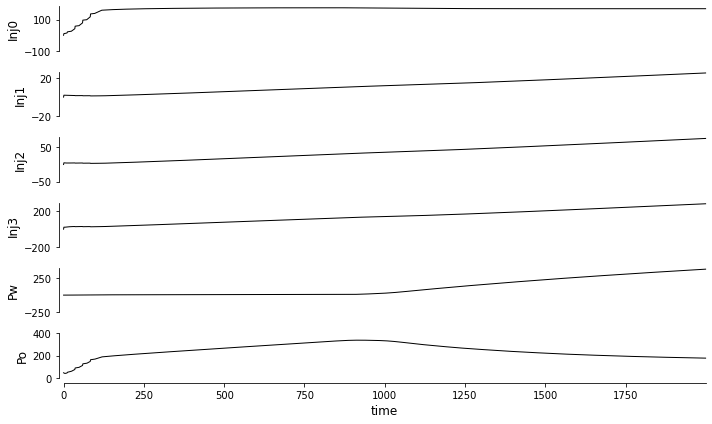

In [ ]:
def jtg_6vars_inj(chosen_data_set):
    """Retunr tg.dataframe of 6 variables: 4 injections and PRODUCTION OF 'Oil & Water'."""
    T = (len(chosen_data_set['time']))
    N = 6
    datax = np.zeros((T,N))
    datax[:,0] = chosen_data_set['rate'][0]['water_rate']
    datax[:,1] = chosen_data_set['rate'][1]['water_rate']
    datax[:,2] = chosen_data_set['rate'][2]['water_rate']
    datax[:,3] = chosen_data_set['rate'][3]['water_rate']
    datax[:,4] = chosen_data_set['rate'][4]['water_rate']
    datax[:,5] = chosen_data_set['rate'][4]['oil_rate']
    print('Vars(',N,') = 4 inj wells, 2 prod_rate = Water & Oil')
    var_names01 = [r'Inj0', r'Inj1', r'Inj2', r'Inj3', r'Pw', r'Po']
    dataframe01 = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names01)
    tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
    return dataframe01;

### tg.data 5 Vars - bhp

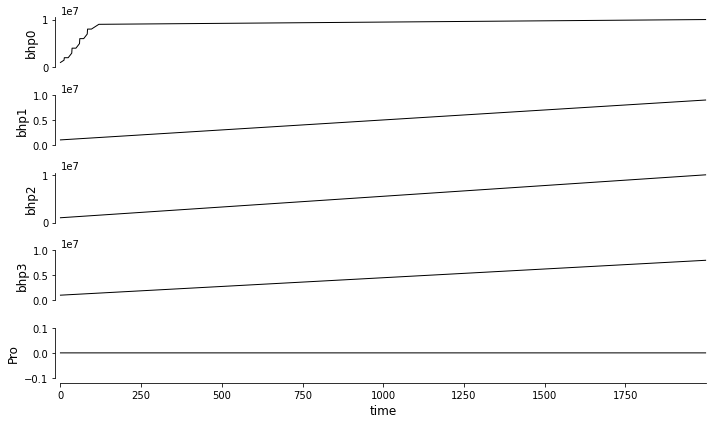

In [ ]:
def jtg_5vars_bhp(chosen_data_set):
    """Retunr tg.dataframe of 5 variables: 4 bhp of inj wells and bhp of Production well."""
    N = 5
    T = (len(chosen_data_set['time']))
    datax = np.zeros((T,N))
    datax[:,0] = chosen_data_set['bhp'][0]
    datax[:,1] = chosen_data_set['bhp'][1]
    datax[:,2] = chosen_data_set['bhp'][2]
    datax[:,3] = chosen_data_set['bhp'][3]
    datax[:,4] = chosen_data_set['bhp'][4]
    print('Vars(',N,') = 4 inj wells [bhp], 1 Pro well [bhp]')
    print('col1-var1',datax[:,0][0:1],'col2-var2',datax[:,1][0:1],'col3-var3',datax[:,2][0:1],'col4-var4',datax[:,3][0:1],'col5-var5',datax[:,4][0:1])
    print('array shape',datax.shape)
    var_names01 = [r'bhp0', r'bhp1', r'bhp2', r'bhp3', r'Pro']
    dataframe01 = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names01)
    tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
    return dataframe01;

### tg.data 6 vars - bhp

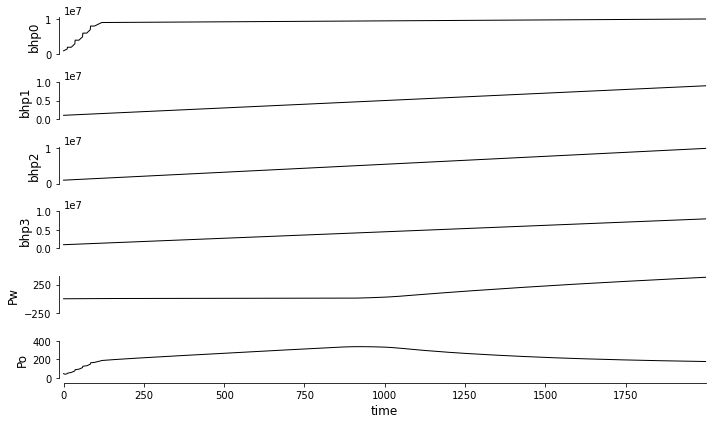

In [ ]:
def jtg_6vars_bhp(chosen_data_set):
    """Retunr tg.dataframe of 6 variables: 4 injections bhp and PRODUCTION OF 'Oil & Water'."""
    T = (len(chosen_data_set['time']))
    N = 6
    datax = np.zeros((T,N))
    datax[:,0] = chosen_data_set['bhp'][0]
    datax[:,1] = chosen_data_set['bhp'][1]
    datax[:,2] = chosen_data_set['bhp'][2]
    datax[:,3] = chosen_data_set['bhp'][3]
    datax[:,4] = chosen_data_set['rate'][4]['water_rate']
    datax[:,5] = chosen_data_set['rate'][4]['oil_rate']
    print('Vars(',N,') = 4 inj wells, 2 prod_rate = Water & Oil')
    var_names01 = [r'bhp0', r'bhp1', r'bhp2', r'bhp3', r'Pw', r'Po']
    dataframe01 = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names01)
    tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
    return dataframe01;

### tg.data Sinuidal Signals 0

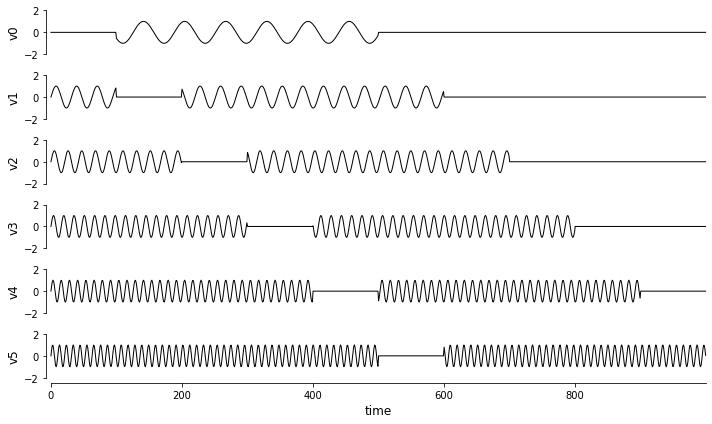

In [ ]:
def jtg_create_TgSin_dataframe_0(t):
  """Creates a "Discontinuous" Sinusoidal Signal 
  dataframe for Tigramite with pre-defined parameters. 
  E.g. t = time-series length. """
  print("Tigramite DataFrame")
  T = t #time-series length
  nv01 = 6 # number of variables 
  data01 = np.zeros((((T)),nv01));
  
  x0 = np.sin(np.linspace(0,100,(T)));x0[000:100] = 0; x0[500:1000] = 0; x0[1500:] = 0;
  data01[:,0]= x0

  x1 = np.sin(np.linspace(0,200,(T)));x1[100:200] = 0; x1[600:1100] = 0; x1[1600:] = 0;
  data01[:,1]= x1

  x2 = np.sin(np.linspace(0,300,(T)));x2[200:300] = 0; x2[700:1200] = 0; x2[1900:] = 0;
  data01[:,2]= x2

  x3 = np.sin(np.linspace(0,400,(T)));x3[300:400] = 0; x3[800:1300] = 0; x3[1800:] = 0;
  data01[:,3]= x3
  
  x4 = np.sin(np.linspace(0,500,(T)));x4[400:500] = 0; x4[900:1400] = 0; x4[1700:] = 0;
  data01[:,4]= x4

  x5 = np.sin(np.linspace(0,600,(T)));x5[500:600] = 0; x5[1000:1500] = 0; x5[1600:] = 0;
  data01[:,5]= x5

  var_names01 = [r'v0', r'v1', r'v2', r'v3', r'v4', r'v5']
  dataframe01 = pp.DataFrame(data01, 
                           datatime = np.arange(len(data01)), 
                           var_names=var_names01)
  tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
  return dataframe01;

### tg.data Sinuidal Signals 1
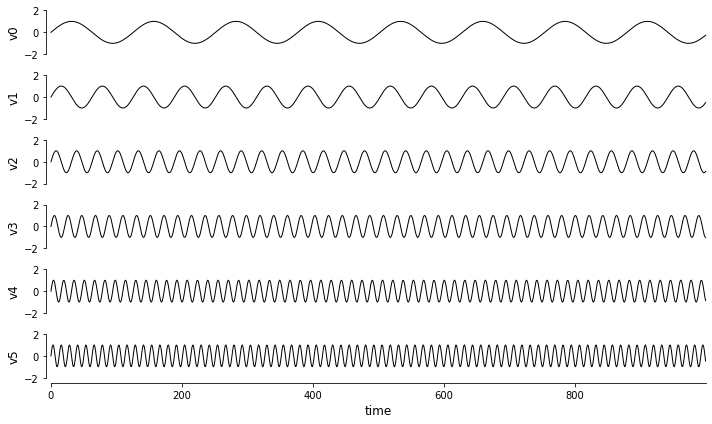


In [ ]:
def jtg_create_TgSin_dataframe_1(t):
  """t = time-series length. Creates a Sinusoidal
  Signal dataframe for Tigramite with defined parameters"""
  print("Type: Tigramite DataFrame.")
  T = t #time-series length
  nv01 = 6 # number of variables 
  data01 = np.zeros((((T)),nv01));
  data01[:,0]= np.sin(np.linspace(0,50,(T)));
  data01[:,1]= np.sin(np.linspace(0,100,(T)));
  data01[:,2]= np.sin(np.linspace(0,200,(T)));
  data01[:,3]= np.sin(np.linspace(0,300,(T)));
  data01[:,4]= np.sin(np.linspace(0,400,(T)));
  data01[:,5]= np.sin(np.linspace(0,500,(T)));

  var_names01 = [r'v0', r'v1', r'v2', r'v3', r'v4', r'v5']
  dataframe01 = pp.DataFrame(data01, 
                           datatime = np.arange(len(data01)), 
                           var_names=var_names01)
  tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
  return dataframe01;

### tg.data Sinuidal Signals 2
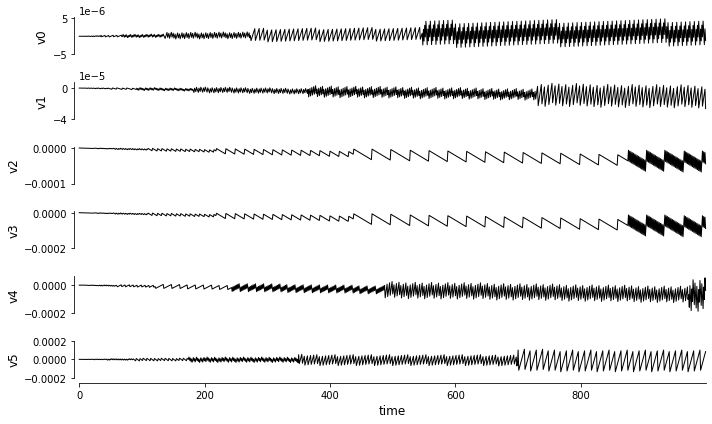

In [ ]:
def jtg_create_TgSin_dataframe_2(t,a,b,c,d,e,f):
  """(JDeCarli) #t = time-series length. #a...f = values for frequencies (MHz)
  for the Signals. Creates a Sinusoidal Signal dataframe for Tigramite with 
  defined parameters. All amplitudes = 1. Start time = 0"""
  T = t #time-series length
  nv01 = 6 # number of variables 
  data01 = np.zeros((((T)),nv01));
  start_time = 0
  end_time = t #time_length
  time = np.arange(start_time, end_time)#, 1/sample_rate)
  #f=np.array([1,2,3,4,5,6]) # array with the wanted frequencies
  f=np.array([a,b,c,d,e,f]) 
  f0 = f[0]*(10**6); a0 = 1;
  f1 = f[1]*(10**6); a1 = 1
  f2 = f[2]*(10**6); a2 = 1
  f3 = f[3]*(10**6); a3 = 1
  f4 = f[4]*(10**6); a4 = 1
  f5 = f[5]*(10**6); a5 = 1

  data01[:,0]= a0 * np.sin(2 * np.pi * f0 * time)
  data01[:,1]= a1 * np.sin(2 * np.pi * f1 * time)
  data01[:,2]= a2 * np.sin(2 * np.pi * f2 * time)
  data01[:,3]= a3 * np.sin(2 * np.pi * f3 * time)
  data01[:,4]= a4 * np.sin(2 * np.pi * f4 * time)
  data01[:,5]= a5 * np.sin(2 * np.pi * f5 * time)

  var_names01 = [r'v0', r'v1', r'v2', r'v3', r'v4', r'v5']
  dataframe01 = pp.DataFrame(data01, 
                           datatime = np.arange(len(data01)), 
                           var_names=var_names01)
  tp.plot_timeseries(dataframe01, figsize=(10,6)); plt.show()
  return dataframe01;

### tg.data 6vars np.random.seed
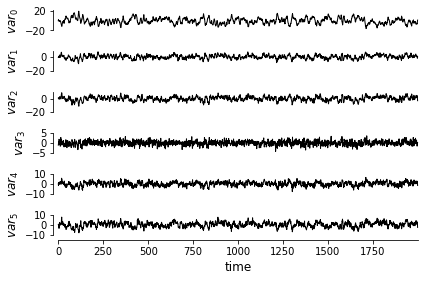

In [ ]:
def jtg_create_NpRandomSeed(T):
  """
  T = time-series length.
  This function will RETURN a synthetic  np.random.seed array which
  will be converted as tigramite.dataframe  
  """
  np.random.seed(18)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  4: [((2, -1), 0.5), ((3, -3), 0.6)],
                  5: [((1, -1), 0.2), ((1, -2), 0.5), ((2, -2), 0.2)],
                  }
  T = T     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

  # Initialize dataframe object, specify time axis and variable names
  var_names = [r'$var_0$', r'$var_1$',r'$var_2$',r'$var_3$', r'$var_4$', r'$var_5$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)

  tp.plot_timeseries(dataframe); plt.show()
  return dataframe;

In [ ]:
print("Functions def in this notebook...")
print([f.__name__ for f in globals().values() if type(f) == type(lambda *args: None)])

Functions def in this notebook...
['register', 'plot_acf', 'plot_pacf', 'j_corrcoef_2ts_plot', 'jp_all_bhp_cruves', 'jp_all_bhp_cruves_Pro', 'jp_prod_curves', 'jp_all_inj_curves', 'jp_all_inj_curves_Pro', 'jp_all_prod_curves_datasets', 'jp_multi_axis', 'jp_windows_data1', 'jp_closeup_win_data1', 'jp_inj_pro_diff_win', 'jtg_2vars_inj', 'jtg_5vars_inj', 'jtg_6vars_inj', 'jtg_5vars_bhp', 'jtg_6vars_bhp', 'jtg_create_TgSin_dataframe_0', 'jtg_create_TgSin_dataframe_1', 'jtg_create_TgSin_dataframe_2', 'jtg_create_NpRandomSeed']


# PCMCI Examples

Examples with numpy randon data to exercise and try algorithms and
different calculation methods for PCMCI


## ParCorr

DAG and Time-Series Graph

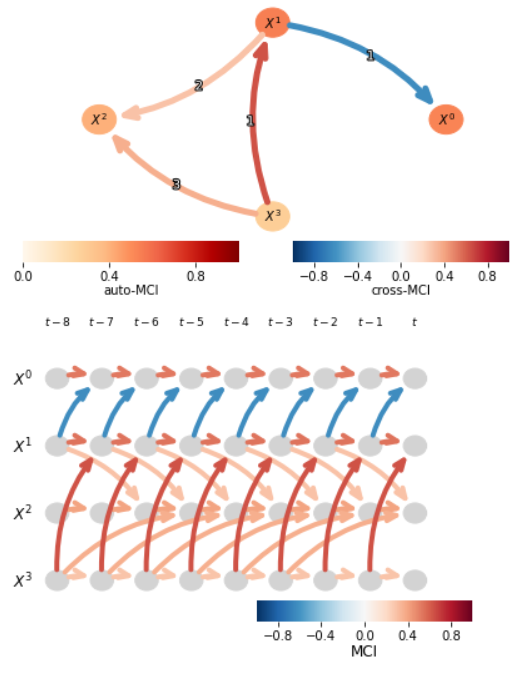

In [ ]:
def jtg_ParCorr_eg():
  '''ParCorr example given'''
  np.random.seed(42)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  }
  T = 300     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

  # Initialize dataframe object, specify time axis and variable names
  var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

# -------------------------------------------------------
  parcorr = ParCorr(significance='analytic')
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=parcorr,
      verbosity=1)
# -------------------------------------------------------

  correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                      'x_base':5, 'y_base':.5}); plt.show()

  pcmci.verbosity = 1
  results = pcmci.run_pcmci(tau_max=8, pc_alpha=1)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
                                       tau_max=8,
                                       fdr_method='fdr_bh')

  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                                             val_matrix=results['val_matrix'],
                                             alpha_level=0.05)['link_matrix']

  tp.plot_graph(
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='cross-MCI',
      node_colorbar_label='auto-MCI',
      ); plt.show()

  tp.plot_time_series_graph(
      figsize=(6, 4),
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='MCI',
      ); plt.show()


**Un-comment the line below to run the example**
```
jtg_ParCorr_eg()
```



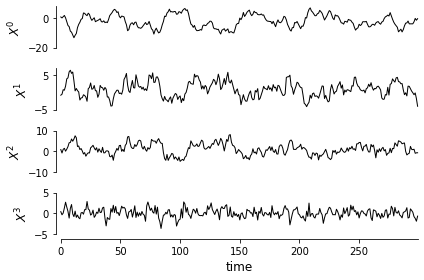


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


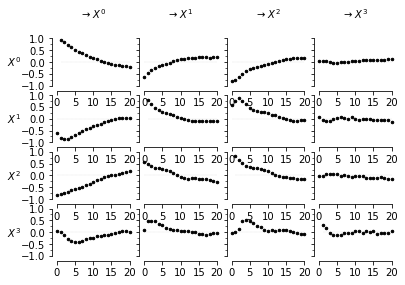


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 32 link(s):
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.620
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.514
        ($X^3$ -3): max_pval = 0.17598, min_val = -0.081
        ($X^3$ -2): max_pval = 0.24806, min_val =  0.069
        ($X^0$ -8): max_pval = 0.31130, min_val =  0.061
        ($X^3$ -5): max_pval = 0.44986, min_val = -0.047
        ($X^2$ -3): max_pval = 0.46314, min_val =  0.044
        ($X^2$ -5): max_pval = 0.58406, min_val = -0.033
        ($X^3$ -1): max_pval = 0.70102, min_val =  0.024
        ($X^1$ -4): max_pval = 0.76852, min_val = -0.019
        ($X^0$ -2): max_pval = 0.77871, min_val = -0.017
        ($X^2$ -1): max_pval = 0.78117, min_val =  0.017
        ($X^2$ -2): max_pval = 0.80300, min_val = -0.015
  

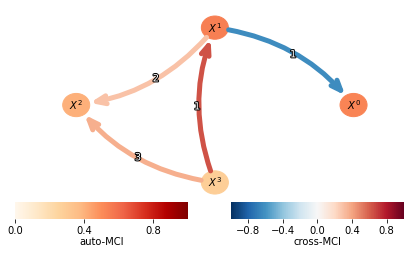

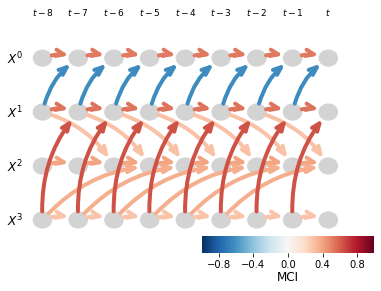

In [ ]:
jtg_ParCorr_eg()

## GPDC

In [ ]:
def jtg_GPDC_eg():
  '''GPDC example given'''
  np.random.seed(42)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  }
  T = 300     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
  var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

# -------------------------------------------------------
  gpdc = GPDC(significance='analytic', gp_params=None)
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=gpdc,
      verbosity=0)
# -------------------------------------------------------

  correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                      'x_base':5, 'y_base':.5}); plt.show()

  pcmci.verbosity = 1
  results = pcmci.run_pcmci(tau_max=8, pc_alpha=1)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
                                         tau_max=8,
                                         fdr_method='fdr_bh')

  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                                               val_matrix=results['val_matrix'],
                                               alpha_level=0.05)['link_matrix']

# Scatter plot

  array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
  x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
  y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
  axes[0].scatter(array[2], array[0], color='grey')
  axes[0].scatter(array[2], meanx, color='black')
  axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
  axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
  axes[1].scatter(array[2], array[1], color='grey')
  axes[1].scatter(array[2], meany, color='black')
  axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
  axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
  axes[2].scatter(x, y, color='red')
  axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
              X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
  axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
  plt.tight_layout()
# -----------

  tp.plot_graph(
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='cross-MCI',
      node_colorbar_label='auto-MCI',
      ); plt.show()

  tp.plot_time_series_graph(
      figsize=(6, 4),
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='MCI',
      ); plt.show()


**Un-comment the line below to run the example**
```
jtg_GPDC_eg()
```

In [ ]:
#jtg_GPDC_eg()

## CMIknn

In [ ]:
def jtg_CMIknn_eg():
  '''CMIknn example given'''
  np.random.seed(42)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  }
  T = 300     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
  var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

  cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=10, transform='ranks')
  pcmci_cmi_knn = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=cmi_knn,
      verbosity=0)
  
  correlations_CMIknn = pcmci_cmi_knn.get_lagged_dependencies(tau_max=10,tau_min=0, val_only=True)['val_matrix']
  lag_func_matrix_CMIknn =tp.plot_lagfuncs(val_matrix=correlations_CMIknn,
                                           setup_args={'var_names':var_names,'figsize':(16,12),
                                                       'minimum':.0,'plot_gridlines':True,'x_base':1, 'y_base':.25});

  link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=results['p_matrix'],
                          val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
  tp.plot_graph(
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='cross-MCI',
      node_colorbar_label='auto-MCI',
      vmin_edges=0.,
      vmax_edges = 0.3,
      edge_ticks=0.05,
      cmap_edges='OrRd',
      vmin_nodes=0,
      vmax_nodes=.5,
      node_ticks=.1,
      cmap_nodes='OrRd',
      ); plt.show()

  tp.plot_time_series_graph(
      figsize=(6, 4),
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='MCI',
      ); plt.show()


**Un-comment the line below to run the example**
```
jtg_CMIknn_eg()
```

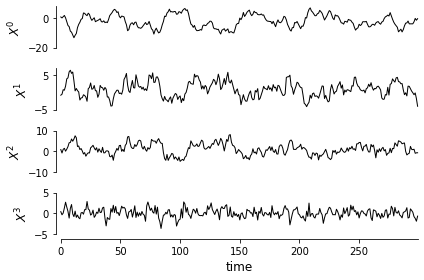

IndexError: ignored

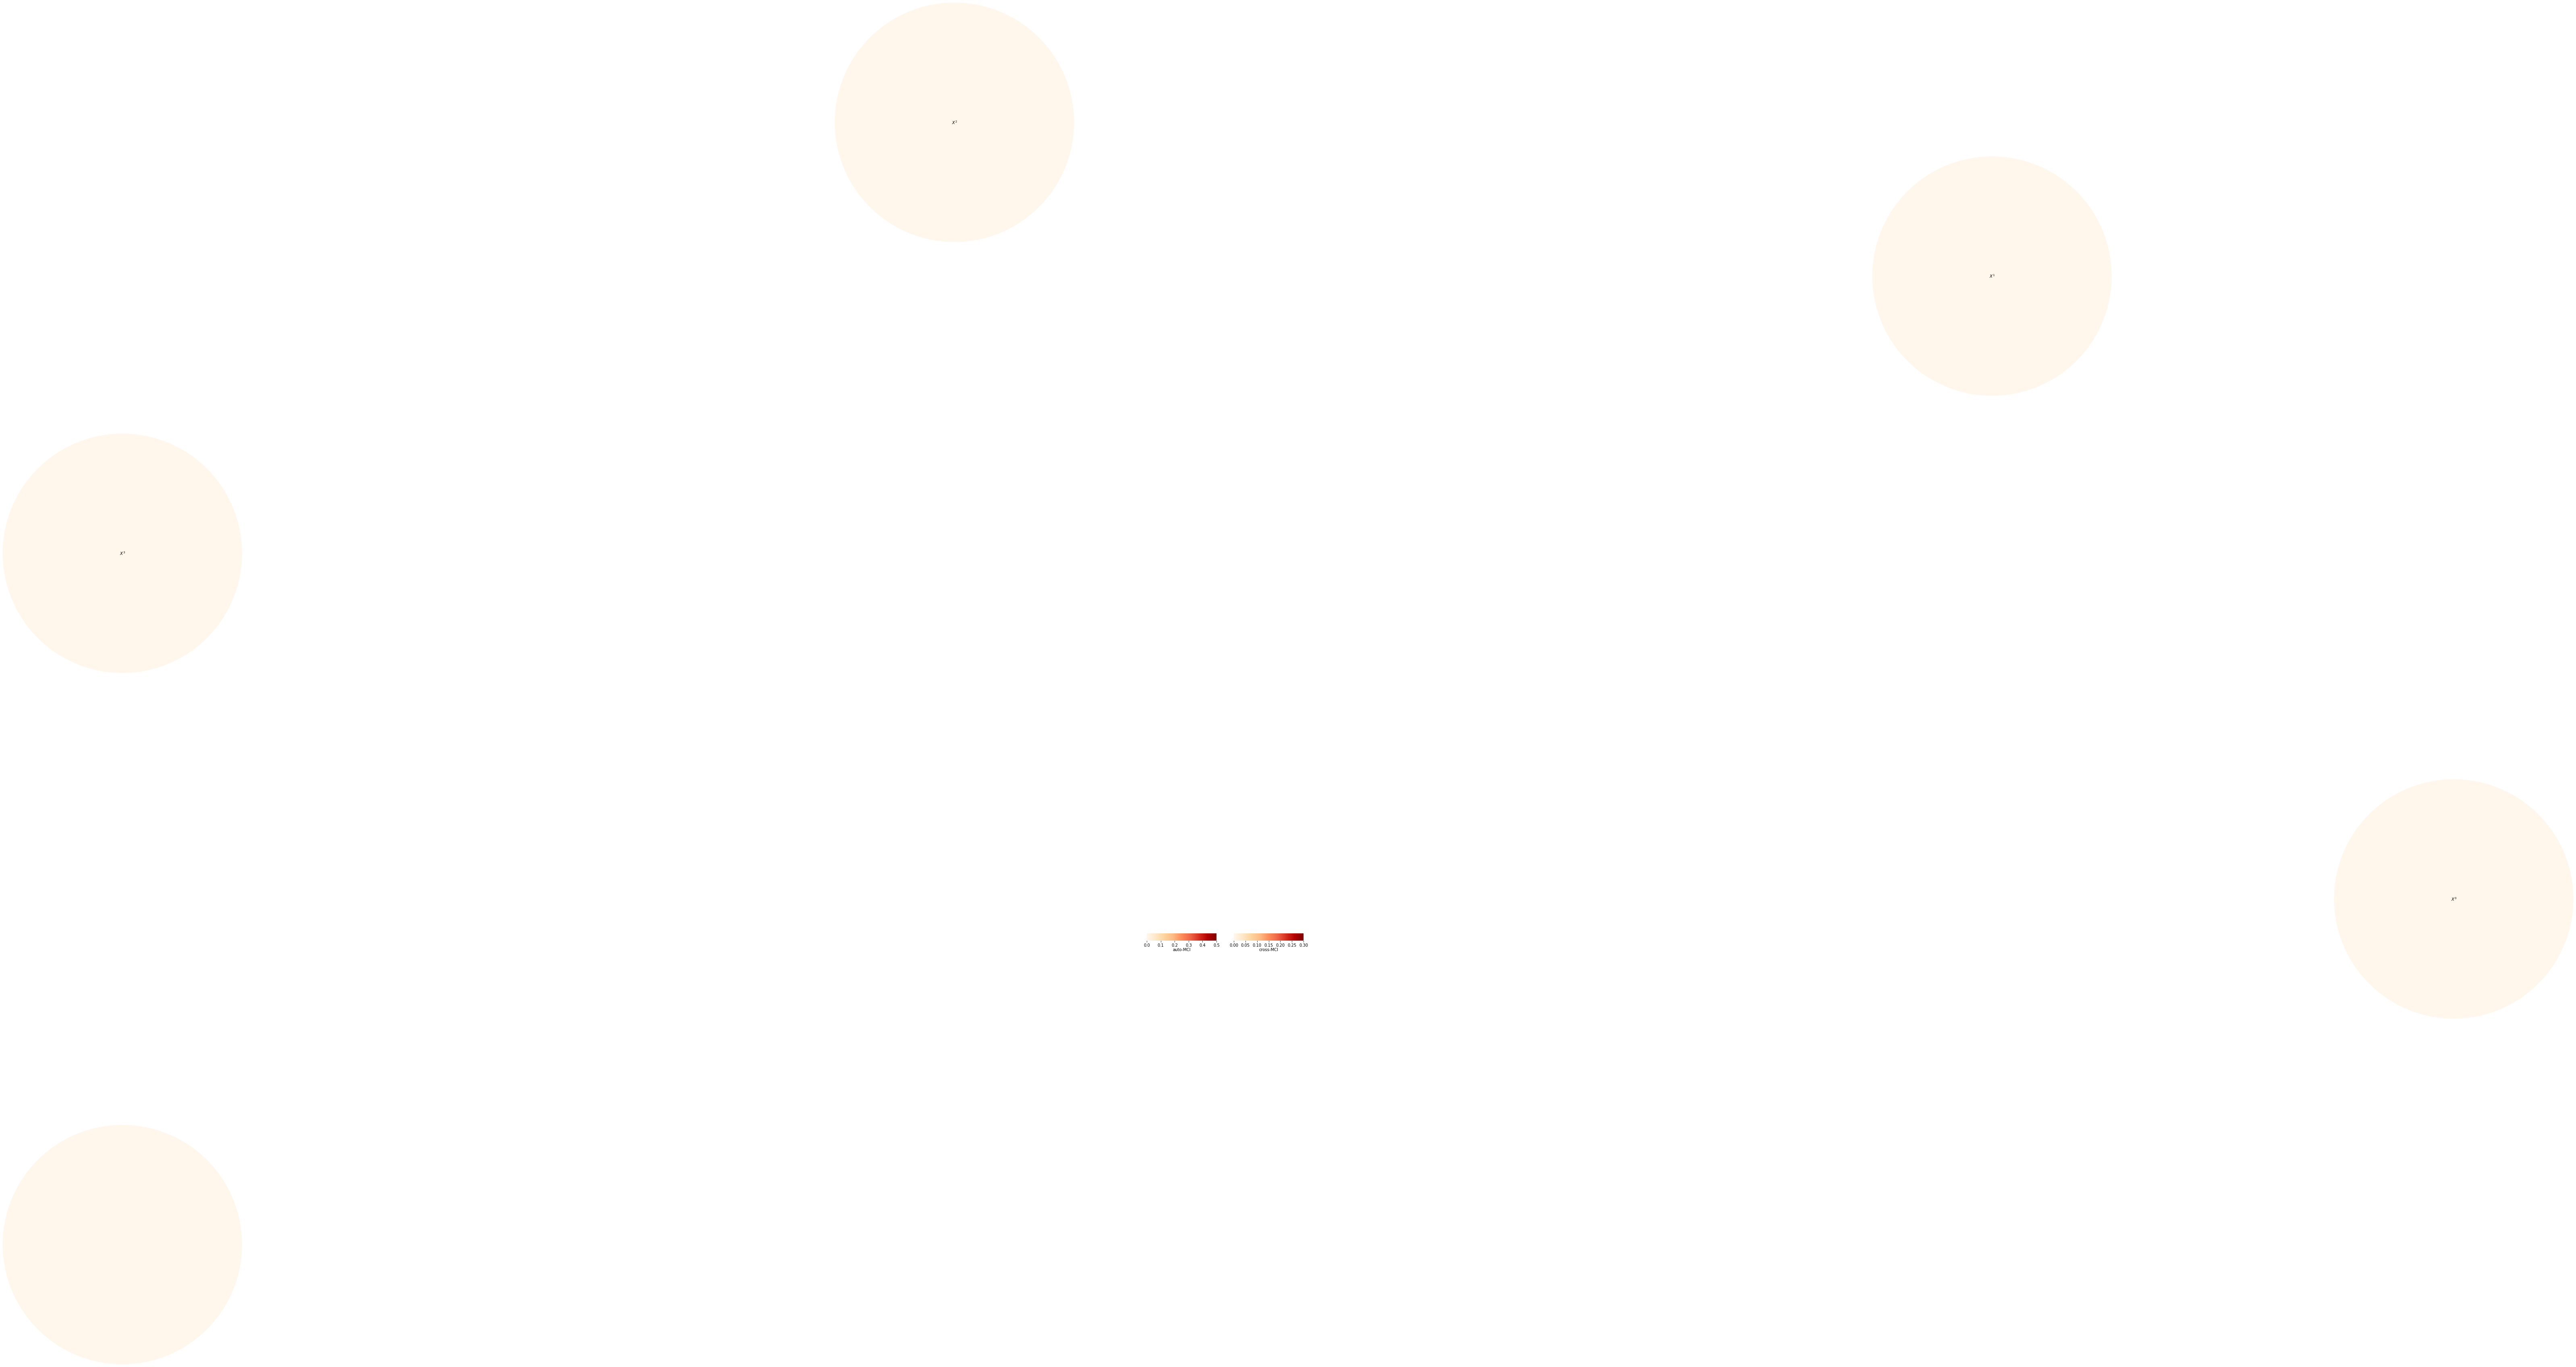

In [ ]:
jtg_CMIknn_eg()

## CMIsymb

In [ ]:
def jtg_CMIsymb_eg():
  '''CMIsymb example given'''
  np.random.seed(42)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  }
  T = 300     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
  var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

  cmi_symb = CMIsymb(significance='shuffle_test', n_symbs=None)
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=cmi_symb,
      verbosity=1)

  correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                      'x_base':5, 'y_base':.5}); plt.show()

  pcmci.verbosity = 1
  results = pcmci.run_pcmci(tau_max=8, pc_alpha=1)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
                                         tau_max=8,
                                         fdr_method='fdr_bh')

  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                                               val_matrix=results['val_matrix'],
                                               alpha_level=0.05)['link_matrix']

  tp.plot_graph(
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='cross-MCI',
      node_colorbar_label='auto-MCI',
      ); plt.show()

  tp.plot_time_series_graph(
      figsize=(6, 4),
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='MCI',
      ); plt.show()


**Un-comment the line below to run the example**
```
jtg_CMIsymb_eg()
```

In [ ]:
#jtg_CMIsymb_eg()

## ParCorr with PCMCI+

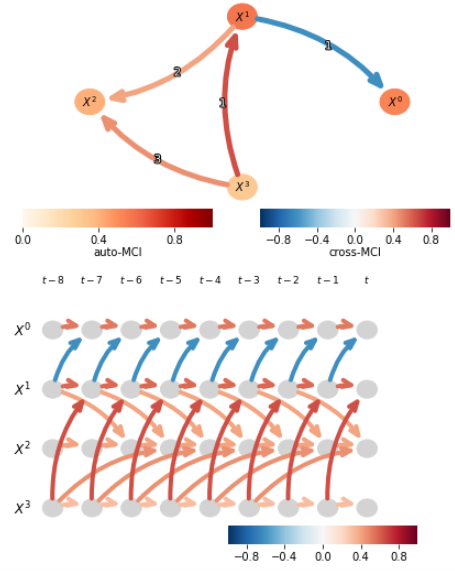

In [ ]:
def jtg_ParCorrPlus_eg():
  '''ParCorr with PCMCI+ example given'''
  np.random.seed(42)     # Fix random seed
  links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                  1: [((1, -1), 0.8), ((3, -1), 0.8)],
                  2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                  3: [((3, -1), 0.4)],
                  }
  T = 300     # time series length
  data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
  T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
  var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
  dataframe = pp.DataFrame(data, 
                           datatime = np.arange(len(data)), 
                           var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

  parcorr = ParCorr(significance='analytic')
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=parcorr,
      verbosity=1)

  correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                      'x_base':5, 'y_base':.5}); plt.show()

  pcmci.verbosity = 1
  results = pcmci.run_pcmciplus(tau_max=8, pc_alpha=0.01)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
                                         tau_max=8,
                                         fdr_method='fdr_bh',
                                         exclude_contemporaneous=False)

  link_matrix = results['graph']

  tp.plot_graph(
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='cross-MCI',
      node_colorbar_label='auto-MCI',
      ); plt.show()

  tp.plot_time_series_graph(
      figsize=(6, 4),
      val_matrix=results['val_matrix'],
      link_matrix=link_matrix,
      var_names=var_names,
      link_colorbar_label='MCI',
      ); plt.show()


**Un-comment the line below to run the example**
```
jtg_ParCorrPlus_eg()
```

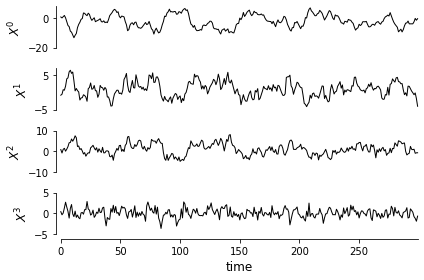


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


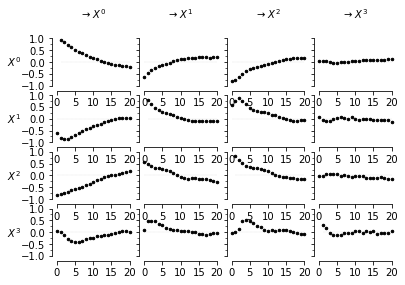


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 2 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.792
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.709

    Variable $X^1$ has 2 link(s):
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.651
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.447

    Variable $X^2$ has 3 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.418
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.400
        ($X^3$ -3): max_pval = 0.00082, min_val =  0.198

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.322

##
## Step 2: PC algorithm with contemp. conditions and MCI tests
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
pc_alpha = 0.01
contemp_collider_rule = maj

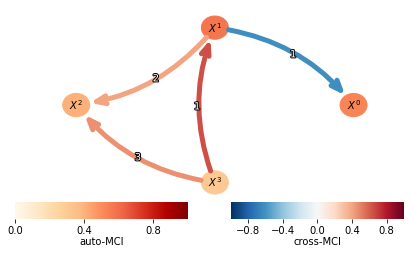

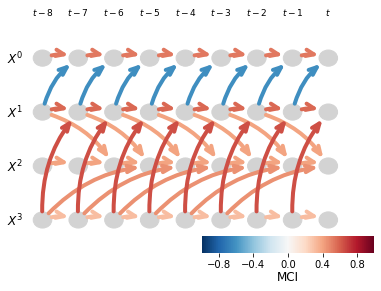

In [ ]:
jtg_ParCorrPlus_eg()

#PCMCI With Simulated Data

## ParCorr

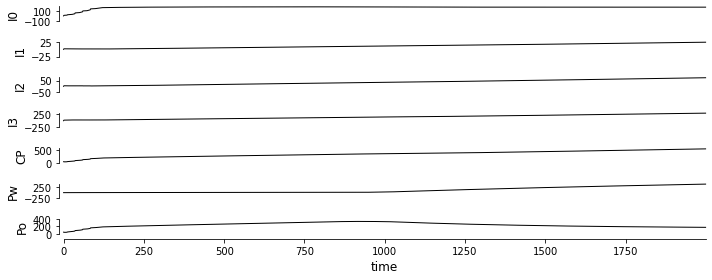

Type the number of Tau_min to be used for calculations:
30
Type the number of Tau_max  to be used for calculations:
40
Selected Causal Links from var_3 (Injector 0) []
Selected Causal Links from var_3 (Injector 1) []
Selected Causal Links from var_3 (Injector 2) []
Selected Causal Links from var_3 (Injector 3) []
Selected Causal Links from var_4 (Cumulative Production) [(0, -30), (0, -31), (0, -32), (0, -33), (0, -34), (0, -35), (0, -36), (0, -37), (0, -38), (0, -39), (0, -40), (1, -30), (1, -31), (1, -32), (1, -33), (1, -34), (1, -35), (1, -36), (1, -37), (1, -38), (1, -39), (1, -40), (2, -30), (2, -31), (2, -32), (2, -33), (2, -34), (2, -35), (2, -36), (2, -37), (2, -38), (2, -39), (2, -40), (3, -30), (3, -31), (3, -32), (3, -33), (3, -34), (3, -35), (3, -36), (3, -37), (3, -38), (3, -39), (3, -40)]
Selected Causal Links from var_5 (Prod of Water) [(4, -30), (4, -31), (4, -32), (4, -33), (4, -34), (4, -35), (4, -36), (4, -37), (4, -38), (4, -39), (4, -40)]
Selected Causal Links from 

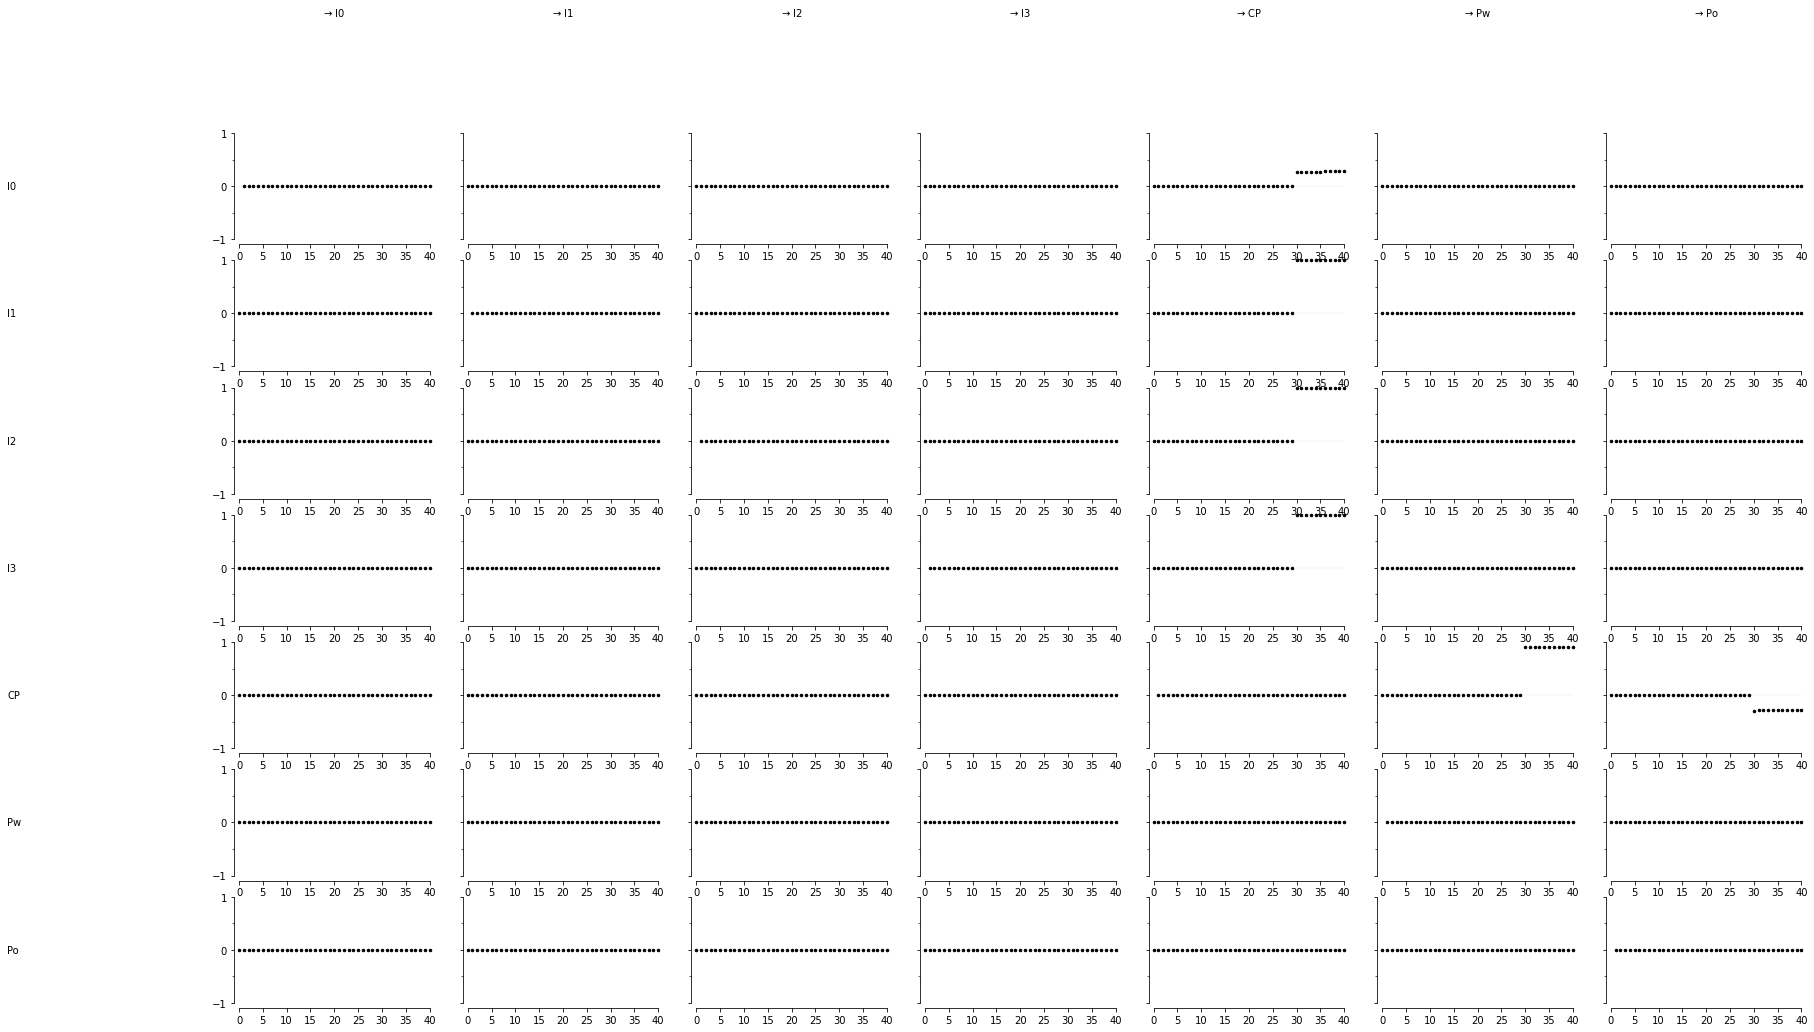

Type pc_alpha value (Significance level in algorithm.
Preferably, choose values in this range
if not sure, choose 1.
([0.001, 0.005, 0.01, 0.025, 0.05, 0.1,..., 1, 2])):
1
pc_alpha value =  1
Alpha_level (Significance level in algorithm.
diff from PC_alpha.Default 0.05
if not sure, choose 0.05, or 0.1, or 1.
Look documentation for more details
1
pc_alpha value =  1

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [], 1: [], 2: [], 3: [], 4: [(0, -30), (0, -31), (0, -32), (0, -33), (0, -34), (0, -35), (0, -36), (0, -37), (0, -38), (0, -39), (0, -40), (1, -30), (1, -31), (1, -32), (1, -33), (1, -34), (1, -35), (1, -36), (1, -37), (1, -38), (1, -39), (1, -40), (2, -30), (2, -31), (2, -32), (2, -33), (2, -34), (2, -35), (2, -36), (2, -37), (2, -38), (2, -39), (2, -40), (3, -30), (3, -31), (3, -32), (3, -33), (3, -34), (3, -35), (3, -36), (3, -37), (3, -38), (3, -39), (3, -40)], 5: [(4, -30), (4, -31), (4, -32), (4, -33), (4, -34), (4, -35), (4, -36),

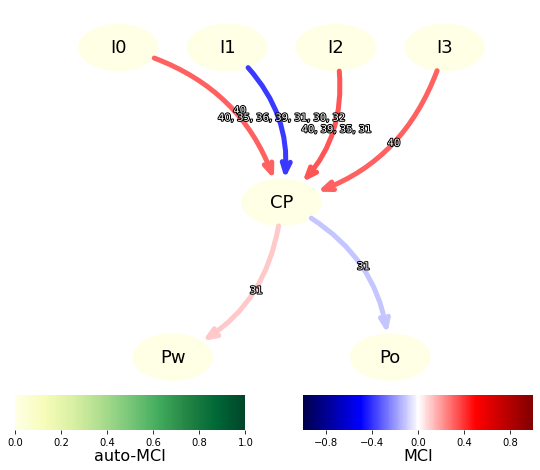

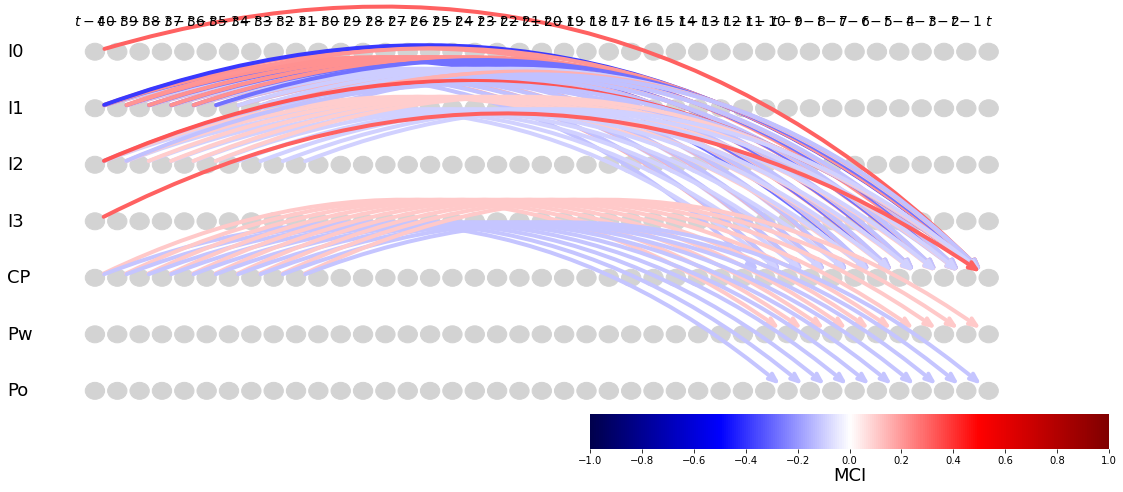

In [ ]:
def jtg_ParCorr(chosen_data_set):
  '''Insert chosen_data_set. ParCorr test with synthetic reservoir data'''
  chosen_data_set = chosen_data_set
  T = (len(chosen_data_set['time']))
  N = 7
  datax = np.zeros((T,N))
  datax[:,0] = chosen_data_set['rate'][0]['water_rate']
  datax[:,1] = chosen_data_set['rate'][1]['water_rate']
  datax[:,2] = chosen_data_set['rate'][2]['water_rate']
  datax[:,3] = chosen_data_set['rate'][3]['water_rate']
  datax[:,4] = (chosen_data_set['rate'][4]['water_rate']) + (chosen_data_set['rate'][4]['oil_rate'])
  datax[:,5] = chosen_data_set['rate'][4]['water_rate']
  datax[:,6] = chosen_data_set['rate'][4]['oil_rate']
  var_names = [r'I0', r'I1', r'I2', r'I3', r'CP', r'Pw', r'Po']
  dataframe = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names)
  tp.plot_timeseries(dataframe, figsize=(10,4)); plt.show()
  
  #---- Selected links
  print("Type the number of Tau_min to be used for calculations:")
  jtau_min = int(input())
  print('Type the number of Tau_max  to be used for calculations:')
  jtau_max = int(input())

  tau_min = jtau_min
  tau_max = jtau_max
  selected_linksx = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}

  selected_linksx[4] = [(var, -lag) for var in range(4) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[5] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[6] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]

  print("Selected Causal Links from var_3 (Injector 0)", selected_linksx[0])
  print("Selected Causal Links from var_3 (Injector 1)", selected_linksx[1])
  print("Selected Causal Links from var_3 (Injector 2)", selected_linksx[2])
  print("Selected Causal Links from var_3 (Injector 3)", selected_linksx[3])
  print("Selected Causal Links from var_4 (Cumulative Production)", selected_linksx[4])
  print("Selected Causal Links from var_5 (Prod of Water)", selected_linksx[5])
  print("Selected Causal Links from var_6 (Prod of Oil)", selected_linksx[6])

  # ---- Method of Calculation
  parcorr = ParCorr(significance='analytic')
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=parcorr,
      verbosity=1)

  # ---- Plotting Correlation Graph

  print("Type the number of Tau_min to be plot on correlation graph:")
  jtau_min_g = int(input())
  print('Type the number of Tau_max  to be plot on correlation graph:')
  jtau_max_g = int(input())

  correlations = pcmci.get_lagged_dependencies(selected_links=selected_linksx, tau_min = jtau_min_g,
                                              tau_max = jtau_max_g,
                                              val_only=True)['val_matrix']

  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations,
                                    setup_args={'var_names':var_names,
                                                'figsize':(28, 16),
                                                'x_base':5,
                                                'y_base':1}); plt.show()

  print('Type pc_alpha value (Significance level in algorithm.')
  print('Preferably, choose values in this range')
  print('if not sure, choose 1.')
  print('([0.001, 0.005, 0.01, 0.025, 0.05, 0.1,..., 1, 2])):')
  jpc_alpha = int(input())
  print('pc_alpha value = ',jpc_alpha)

  print('Alpha_level (Significance level in algorithm.')
  print('diff from PC_alpha.Default 0.05')
  print('if not sure, choose 0.05, or 0.1, or 1.')
  print('Look documentation for more details')
  jalpha_level = int(input())
  print('pc_alpha value = ',jalpha_level)

  pcmci.verbosity = 1
  results = pcmci.run_pcmci(tau_min = jtau_min, tau_max=jtau_max, pc_alpha=jpc_alpha,selected_links=selected_linksx)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],tau_min = jtau_min, tau_max=jtau_max, fdr_method='fdr_bh')

  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix, val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

  node_posx = {'x':np.array((0,0.2,0.4,0.6,0.3,0.1,0.5)), # Var Y position
              'y':np.array((1,  1,1,1,0.5,0,0))} # Var Y position

  #link_width_6v = np.ones((results['val_matrix'].shape))
  #link_width1.shape = (N_vars, N_Vars, Tau_Max+1)
  #link_width_6v[0,:,:] = 1 #   arrows width from Var_names[0] | From [0] variable
  #link_width_6v[1,:,:] = 2 #   arrows width from Var_names[1] | From [1] variable
  #link_width_6v[2,:,:] = 1 #   arrows width from Var_names[2] | From [2] variable
  #link_width_6v[3,:,:] = 0.5 # arrows width from Var_names[3] | From [3] variable
  #link_width_6v[4,:,:] = 0.5 # arrows width from Var_names[4] | From [4] variable
  #link_width_6v[5,:,:] = 0.5 # arrows width from Var_names[4] | From [5] variable

  tp.plot_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(8,8),
      link_colorbar_label='MCI',
      node_colorbar_label='auto-MCI',
      node_pos=node_posx,
      arrow_linewidth=10.0,
      vmin_edges=-1,
      vmax_edges=1.0,
      edge_ticks=0.4, #0.4
      cmap_edges='seismic',#'RdBu_r',
      vmin_nodes=0,
      vmax_nodes=1.0,
      node_ticks=0.2, #0.4
      cmap_nodes='YlGn',#OrRd
      node_size=0.15, #0.3
      arrowhead_size=20,
      curved_radius=0.3,
      label_fontsize=16, #10
      alpha=1.0,
      node_label_size=18, #10
      link_label_fontsize=10,
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

  tp.plot_time_series_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(18,8),
      link_colorbar_label='MCI',
      save_name=None,
      link_width=None,
      link_attribute=None,
      arrow_linewidth=8,
      vmin_edges=-1, #-1
      vmax_edges=1.0,
      edge_ticks=0.2, #0.4
      cmap_edges='seismic', #'RdBu_r'
      order=None,
      node_size=0.05, #0.1
      node_aspect=None, #None
      arrowhead_size=10, #20
      curved_radius=0.3, #0.2
      label_fontsize=18,
      alpha=1, #1.0
      node_label_size=2,
      label_space_left=0.1, #0.1
      label_space_top=0.1, #0.0
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

## CMIknn

For around 10lags (tau min =0 and taumax=11) this code cell took 4 hours and 10 min to run

In [ ]:
def jtg_CMIknn(chosen_data_set):
  '''Insert chosen_data_set. CMIknn test with synthetic reservoir data'''
  chosen_data_set = chosen_data_set
  T = (len(chosen_data_set['time']))
  N = 7
  datax = np.zeros((T,N))
  datax[:,0] = chosen_data_set['rate'][0]['water_rate']
  datax[:,1] = chosen_data_set['rate'][1]['water_rate']
  datax[:,2] = chosen_data_set['rate'][2]['water_rate']
  datax[:,3] = chosen_data_set['rate'][3]['water_rate']
  datax[:,4] = (chosen_data_set['rate'][4]['water_rate']) + (chosen_data_set['rate'][4]['oil_rate'])
  datax[:,5] = chosen_data_set['rate'][4]['water_rate']
  datax[:,6] = chosen_data_set['rate'][4]['oil_rate']
  var_names = [r'I0', r'I1', r'I2', r'I3', r'CP', r'Pw', r'Po']
  dataframe = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names)
  tp.plot_timeseries(dataframe, figsize=(10,4)); plt.show()
  #---- Selected links
  print("Type the number of Tau_min to be used for calculations:")
  jtau_min = int(input())
  print('Type the number of Tau_max  to be used for calculations:')
  jtau_max = int(input())

  tau_min = jtau_min
  tau_max = jtau_max
  selected_linksx = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}

  selected_linksx[4] = [(var, -lag) for var in range(4) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[5] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[6] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]

  print("Selected Causal Links from var_3 (Injector 0)", selected_linksx[0])
  print("Selected Causal Links from var_3 (Injector 1)", selected_linksx[1])
  print("Selected Causal Links from var_3 (Injector 2)", selected_linksx[2])
  print("Selected Causal Links from var_3 (Injector 3)", selected_linksx[3])
  print("Selected Causal Links from var_4 (Cumulative Production)", selected_linksx[4])
  print("Selected Causal Links from var_5 (Prod of Water)", selected_linksx[5])
  print("Selected Causal Links from var_6 (Prod of Oil)", selected_linksx[6])

  # ---- Method of Calculation
  cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
  pcmci_cmi_knn = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=cmi_knn,
      verbosity=2)
  results = pcmci_cmi_knn.run_pcmci(selected_links=selected_linksx, tau_max=6, pc_alpha=0.05)
  pcmci_cmi_knn.print_significant_links(
          p_matrix = results['p_matrix'], 
          val_matrix = results['val_matrix'],
          alpha_level = 0.01)

  # ---- Plotting Correlation Graph

  print("Type the number of Tau_min to be plot on correlation graph:")
  jtau_min_g = int(input())
  print('Type the number of Tau_max  to be plot on correlation graph:')
  tau_max_g = int(input())

  link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=results['p_matrix'],
                          val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

  print('Type pc_alpha value (Significance level in algorithm.')
  print('Preferably, choose values in this range')
  print('if not sure, choose 1.')
  print('([0.001, 0.005, 0.01, 0.025, 0.05, 0.1,..., 1, 2])):')
  jpc_alpha = int(input())
  print('pc_alpha value = ',jpc_alpha)
  print('Alpha_level (Significance level in algorithm.')
  print('diff from PC_alpha.Default 0.05')
  print('if not sure, choose 0.05, or 0.1, or 1.')
  print('Look documentation for more details')
  jalpha_level = int(input())
  print('pc_alpha value = ',jalpha_level)

  node_posx = {'x':np.array((0,0.2,0.4,0.6,0.3,0.1,0.5)), # Var Y position
               'y':np.array((1,  1,1,1,0.5,0,0))} # Var Y position

# --- if the link (arrows) width need to be different

  #link_width = np.ones((results['val_matrix'].shape))
  #link_width.shape = (N_vars, N_Vars, Tau_Max+1)
  #link_width[0,:,:] = 1 #   arrows width from Var_names[0] | From [0] variable
  #link_width[1,:,:] = 2 #   arrows width from Var_names[1] | From [1] variable
  #link_width[2,:,:] = 1 #   arrows width from Var_names[2] | From [2] variable
  #link_width[3,:,:] = 0.5 # arrows width from Var_names[3] | From [3] variable
  #link_width[4,:,:] = 0.5 # arrows width from Var_names[4] | From [4] variable
  #link_width[5,:,:] = 0.5 # arrows width from Var_names[4] | From [5] variable

# --- Plot DAG
  tp.plot_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(8,8),
      link_colorbar_label='MCI',
      node_colorbar_label='auto-MCI',
      node_pos=node_posx,
      arrow_linewidth=10.0,
      vmin_edges=-1,
      vmax_edges=1.0,
      edge_ticks=0.4, #0.4
      cmap_edges='seismic',#'RdBu_r',
      vmin_nodes=0,
      vmax_nodes=1.0,
      node_ticks=0.2, #0.4
      cmap_nodes='YlGn',#OrRd
      node_size=0.15, #0.3
      arrowhead_size=20,
      curved_radius=0.3,
      label_fontsize=16, #10
      alpha=1.0,
      node_label_size=18, #10
      link_label_fontsize=10,
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

# --- Plot time-series graph
  tp.plot_time_series_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(18,8),
      link_colorbar_label='MCI',
      save_name=None,
      link_width=None,
      link_attribute=None,
      arrow_linewidth=8,
      vmin_edges=-1, #-1
      vmax_edges=1.0,
      edge_ticks=0.2, #0.4
      cmap_edges='seismic', #'RdBu_r'
      order=None,
      node_size=0.05, #0.1
      node_aspect=None, #None
      arrowhead_size=10, #20
      curved_radius=0.3, #0.2
      label_fontsize=18,
      alpha=1, #1.0
      node_label_size=2,
      label_space_left=0.1, #0.1
      label_space_top=0.1, #0.0
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

## GPDC

For around 10lags (tau min =0 and taumax=11) this code cell took 2 hours and 25min to run


In [ ]:
def jtg_GPDC(chosen_data_set):
  '''Insert chosen_data_set. GPDC test with synthetic reservoir data'''
  chosen_data_set = chosen_data_set
  T = (len(chosen_data_set['time']))
  N = 7
  datax = np.zeros((T,N))
  datax[:,0] = chosen_data_set['rate'][0]['water_rate']
  datax[:,1] = chosen_data_set['rate'][1]['water_rate']
  datax[:,2] = chosen_data_set['rate'][2]['water_rate']
  datax[:,3] = chosen_data_set['rate'][3]['water_rate']
  datax[:,4] = (chosen_data_set['rate'][4]['water_rate']) + (chosen_data_set['rate'][4]['oil_rate'])
  datax[:,5] = chosen_data_set['rate'][4]['water_rate']
  datax[:,6] = chosen_data_set['rate'][4]['oil_rate']
  var_names = [r'I0', r'I1', r'I2', r'I3', r'CP', r'Pw', r'Po']
  dataframe = pp.DataFrame(datax,datatime = np.arange(len(datax)),var_names=var_names)
  tp.plot_timeseries(dataframe); plt.show()

  #---- Selected links
  print("Type the number of Tau_min to be used for calculations:")
  jtau_min = int(input())
  print('Type the number of Tau_max  to be used for calculations:')
  jtau_max = int(input())

  tau_min = jtau_min
  tau_max = jtau_max

  selected_linksx = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}

  selected_linksx[4] = [(var, -lag) for var in range(4) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[5] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]
  selected_linksx[6] = [(4, -lag) for lag in range(tau_min, tau_max + 1)]

  print("Selected Causal Links from var_3 (Injector 0)", selected_linksx[0])
  print("Selected Causal Links from var_3 (Injector 1)", selected_linksx[1])
  print("Selected Causal Links from var_3 (Injector 2)", selected_linksx[2])
  print("Selected Causal Links from var_3 (Injector 3)", selected_linksx[3])
  print("Selected Causal Links from var_4 (Cumulative Production)", selected_linksx[4])
  print("Selected Causal Links from var_5 (Prod of Water)", selected_linksx[5])
  print("Selected Causal Links from var_6 (Prod of Oil)", selected_linksx[6])

# ---- Method of Calculation
  gpdc = GPDC(significance='analytic', gp_params=None)
  pcmci = PCMCI(
      dataframe=dataframe, 
      cond_ind_test=gpdc,
      verbosity=0)

# ---- Plotting Correlation Graph

  correlations = pcmci.get_lagged_dependencies(selected_links=selected_linksx, tau_min=jtau_min,
                                               tau_max=jtau_max, val_only=True)['val_matrix']

  lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                      'x_base':5, 'y_base':.5}); plt.show()

  pcmci.verbosity = 1
  results = pcmci.run_pcmci(selected_links=selected_linksx, tau_min=jtau_min,
                            tau_max=jtau_max, pc_alpha=0.5)

  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
                                         tau_min=jtau_min,
                                         tau_max=jtau_max,
                                         fdr_method='fdr_bh')

  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                                               val_matrix=results['val_matrix'],
                                               alpha_level=0.05)['link_matrix']

  node_posx = {'x':np.array((0,0.2,0.4,0.6,0.3,0.1,0.5)), # Var Y position
               'y':np.array((1,  1,1,1,0.5,0,0))} # Var Y position

# --- if the link (arrows) width need to be different

  #link_width = np.ones((results['val_matrix'].shape))
  #link_width.shape = (N_vars, N_Vars, Tau_Max+1)
  #link_width[0,:,:] = 1 #   arrows width from Var_names[0] | From [0] variable
  #link_width[1,:,:] = 2 #   arrows width from Var_names[1] | From [1] variable
  #link_width[2,:,:] = 1 #   arrows width from Var_names[2] | From [2] variable
  #link_width[3,:,:] = 0.5 # arrows width from Var_names[3] | From [3] variable
  #link_width[4,:,:] = 0.5 # arrows width from Var_names[4] | From [4] variable
  #link_width[5,:,:] = 0.5 # arrows width from Var_names[4] | From [5] variable

# --- Plot DAG
  tp.plot_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(8,8),
      link_colorbar_label='MCI',
      node_colorbar_label='auto-MCI',
      node_pos=node_posx,
      arrow_linewidth=10.0,
      vmin_edges=-1,
      vmax_edges=1.0,
      edge_ticks=0.4, #0.4
      cmap_edges='seismic',#'RdBu_r',
      vmin_nodes=0,
      vmax_nodes=1.0,
      node_ticks=0.2, #0.4
      cmap_nodes='YlGn',#OrRd
      node_size=0.15, #0.3
      arrowhead_size=20,
      curved_radius=0.3,
      label_fontsize=16, #10
      alpha=1.0,
      node_label_size=18, #10
      link_label_fontsize=10,
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

# --- Plot time-series graph
  tp.plot_time_series_graph(
      link_matrix=link_matrix,
      val_matrix=results['val_matrix'],
      var_names=var_names,
      figsize=(18,8),
      link_colorbar_label='MCI',
      save_name=None,
      link_width=None,
      link_attribute=None,
      arrow_linewidth=8,
      vmin_edges=-1, #-1
      vmax_edges=1.0,
      edge_ticks=0.2, #0.4
      cmap_edges='RdBu_r', #'RdBu_r' # Seismic
      order=None,
      node_size=0.05, #0.1
      node_aspect=None, #None
      arrowhead_size=10, #20
      curved_radius=0.3, #0.2
      label_fontsize=18,
      alpha=1, #1.0
      node_label_size=2,
      label_space_left=0.1, #0.1
      label_space_top=0.1, #0.0
      network_lower_bound=0.2, #0.2
      inner_edge_style='dashed'
      ); plt.show()

**Un-comment the line below to run the example**
```
jtg_GPDC(dataset)

```
For example:
```
jtg_GPDC(data3)
```

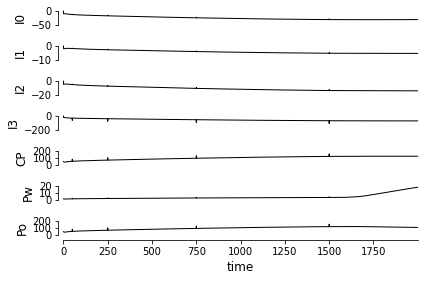

Type the number of Tau_min to be used for calculations:
10
Type the number of Tau_max  to be used for calculations:
13
Selected Causal Links from var_3 (Injector 0) []
Selected Causal Links from var_3 (Injector 1) []
Selected Causal Links from var_3 (Injector 2) []
Selected Causal Links from var_3 (Injector 3) []
Selected Causal Links from var_4 (Cumulative Production) [(0, -10), (0, -11), (0, -12), (0, -13), (1, -10), (1, -11), (1, -12), (1, -13), (2, -10), (2, -11), (2, -12), (2, -13), (3, -10), (3, -11), (3, -12), (3, -13)]
Selected Causal Links from var_5 (Prod of Water) [(4, -10), (4, -11), (4, -12), (4, -13)]
Selected Causal Links from var_6 (Prod of Oil) [(4, -10), (4, -11), (4, -12), (4, -13)]


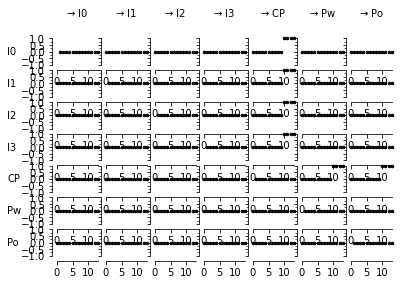


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [], 1: [], 2: [], 3: [], 4: [(0, -10), (0, -11), (0, -12), (0, -13), (1, -10), (1, -11), (1, -12), (1, -13), (2, -10), (2, -11), (2, -12), (2, -13), (3, -10), (3, -11), (3, -12), (3, -13)], 5: [(4, -10), (4, -11), (4, -12), (4, -13)], 6: [(4, -10), (4, -11), (4, -12), (4, -13)]}
independence test = gp_dc
tau_min = 10
tau_max = 13
pc_alpha = [1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable I0 has 0 link(s):

    Variable I1 has 0 link(s):

    Variable I2 has 0 link(s):

    Variable I3 has 0 link(s):

    Variable CP has 16 link(s):
        (I1 -13): max_pval = 0.00000, min_val =  0.998
        (I2 -11): max_pval = 0.00000, min_val =  0.998
        (I2 -10): max_pval = 0.00000, min_val =  0.998
        (I1 -11): max_pval = 0.00000, min_val =  0.998
        (I1 -12): max_pval = 0.00000, min_val =  0.998
        (I1 -10): max_pval = 0.00000, min_v

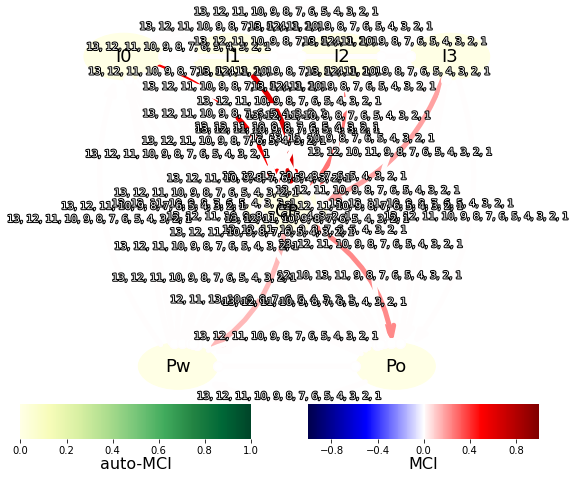

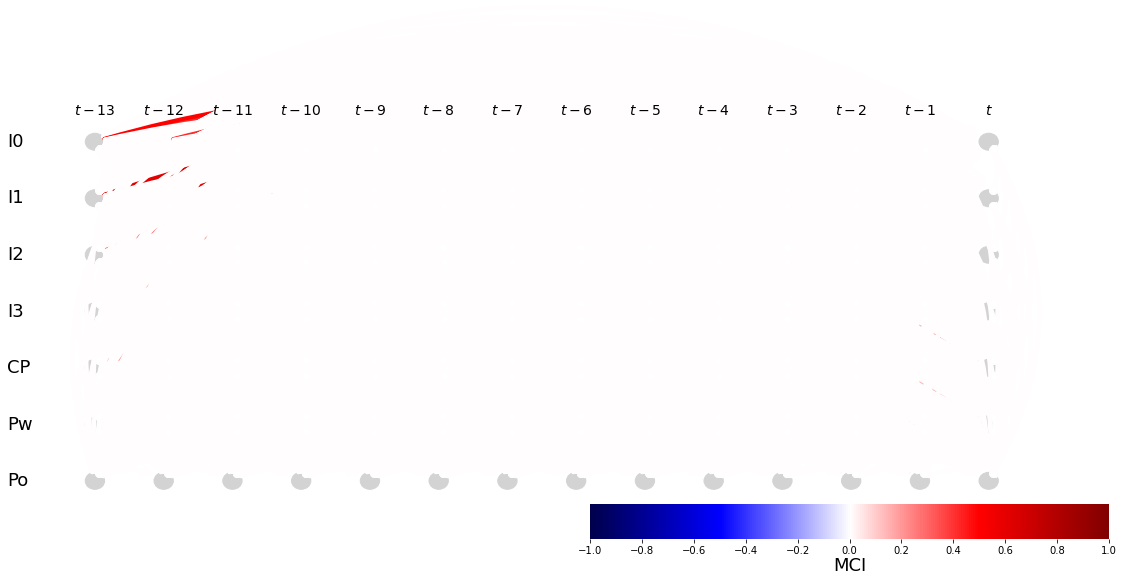

In [ ]:
jtg_GPDC(data4)